# 0 - Set-Up

### Environment Set Up 

In [1]:
# Install required packages
!pip install -qq -r ../requirements.txt

# Set up root directory
import sys

REL_PATH_TO_ROOT = "../"

sys.path.insert(0,REL_PATH_TO_ROOT)

from src.utils import get_root_dir, test_root_dir
from local_variables import ROOT_DIR

test_root_dir(REL_PATH_TO_ROOT)

Root directory set up correctly!


In [2]:
# Get project questions
from questions.questions import questions as QQQQ

### Import Packages

In [3]:
# Import project specific packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from scipy.stats import mannwhitneyu
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import dask.dataframe as dd
from dask.delayed import delayed
import dask
from sklearn.linear_model import Ridge

/home/parthian-sunrise/projects/udacity-ds-project-blog/venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Licences

In this project we use the following packages, printed from the cell below

In [4]:
requirements = [
    "numpy",
    "pandas",
    "black",
    "flake8",
    "kagglehub",
    "matplotlib",
    "seaborn",
    "sklearn",
    "tqdm",
    "dask"
]

# Loop through the requirements and print their versions
for package in requirements:
    try:
        # Import the package dynamically
        mod = __import__(package.replace("-", "_"))  # Replace hyphens with underscores for imports
        version = getattr(mod, "__version__", "Version attribute not found")
        print(f"{package}: {version}")
    except ImportError:
        print(f"{package}: Not installed")


numpy: 2.1.3
pandas: 2.2.3
black: 24.10.0
flake8: 7.1.1
kagglehub: 0.3.4
matplotlib: 3.9.2
seaborn: 0.13.2
sklearn: 1.5.2
tqdm: 4.67.1
dask: 2024.12.0


/home/parthian-sunrise/projects/udacity-ds-project-blog/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Business Understanding

## I - The Questions We Want to Answer

In [5]:
# Print out questions
def get_question(question_num):
    print(QQQQ[question_num])

for i in range(1,5):
    get_question(str(i))

Q1: How much do neighbourhoods affect the price of AirBnbs?
Q2: 花見 (hanami) is the Japanese practice of watching cherry blossoms bloom, in Japan due to a previous blight among the tree population around 80% of cherry blossoms are genetically identical meaning the vast majority will bloom under the same conditions. Forecasts exist and are well known, for the date of mass blooming. Does the date of blooming seem to impact the price?
Q3: Which features of the dataset have the best predictive power for the price of a property based on linear regression?
Q4 : What are the features that best predict superhost status?


While these questions do not necessarily align perfectly with a business problem, they are an interesting excercise in understanding a business market, specifically that of accomodation and AirBnbs. Question 1 and 2 may be more suited to view from the perspective of a consumer, while Questions 3 and 4 may be more suited to view from a business perspective (such as AirBnb itself).

### Q1

When it comes to choosing where in a city to stay, there's a lot of factors to consider. Some are deadset on staying in a specific area while others are more free to stay anywhere as they they are less concerned with property location (say if they expect to always be out and about). 

Hence for this question I want to look at the distribution of price by neighbourhood and understand how much of a determining factor it plays in the price of an AirBnb stay.

### Q2 

For Japan specifically, there could be many reasons to visit. A salient reason nonetheless for many is to see the blooming of the cherry blossoms. 

Due to the low species diversity of the cherry blossoms in Japan they tend to bloom at the same time and hence forecasts exists and are widely publicised both domestically and abroad for tourists, hence it is reasonable to expect that there may be an impact of the seaon on the prices of AirBnbs as demand may outstrip supply. 

To answer this question we will want to identify a season in the data that covers either side of the cherry blossom blooming season and use some form of changepoint analysis to see if we can detect a significant difference in the price distributions. 

### Q3

Next, from a more business minded perspective we may be interested in understanding the variables which tend to drive the price of an AirBnb. While at an individual level it may not be captured at any model, when looking at the cohort of Airbnbs within the city of Tokyo we may find that there are general features or variables which have a large predictive relationship with the prices of Airbnbs. In order to do this we must first understand our data, the features within it and then isolate the variables of interest which we believe could have a predictive capacity. 

Then in order to identify the best combination of features, we can select random groups of features and compare objective metrics relating to the model's accuracy or performance to see which of the groups of features seem to perform the best and hence (under a linear regression view) have the best predictive power.

### Q4 

Similarly, when looking say from the perspective of AirBnb we may want to understand the types of people becoming superhost to see if it matches with our criteria for what a superhost ought to be. One way of doing this would be similar to the approach for Q3, that is to say, we run a random selection process on a predefined set of features deem adequate and then using objective model metrics to get a view of which combination of features generally performed best.

## II - The choice of data

For this project I am using the AirBnB data for Tokyo. While this does not represent the entire rental scene in Tokyo with regards to Q1-Q3, it is a good public dataset for a company with sizeable marketshare in the holiday let rental sector and given the public license of the data it makes a sensible choice for a preliminary analysis.

As for the specific data items themselves, I am looking to use two datasets. The first is a calendar dataframe, this contain information regarding the property and attributes thereof over time such as its price day to day, occupancy etc. 

Secondly I am using a 'listings' dataset which contains static information about the property; including but not limited to information about the host, information regarding the property's location and size etc. 

Finally, although in the end this dataset did not prove useful, I brought in a dataset about the dates of blooming of cherry blossoms to help with the analysis of Q2. As I say following the EDA on it it was not suitable for the task and hence a single source was used for the cherry blossom dates in Tokyo and this is sourced and brought in in the appropriate place in the notebook.

Given the huge size of the datasets it is not feasible to do a thorough analysis of every single feature, nonetheless I have done my best to provide an analysis where a feature has a ready interpretation.

# Load Data

Here we bring in the data we are looking to use to answer our business questions

In [6]:
# Relevant files for AirBnB
files_of_interest = ["calendar.csv","listings.csv"]
years = ["2023","2024"]

In [7]:
# Concatenate for 2023 and 2024
cal_df = pd.concat([pd.read_csv(f"{get_root_dir()}/data/{year}_tokyo/calendar.csv") for year in years],ignore_index=True)

In [8]:
# Concatenate for 2023 and 2024
list_df = pd.concat([pd.read_csv(f"{get_root_dir()}/data/{year}_tokyo/listings.csv") for year in years],ignore_index=True)

/tmp/ipykernel_2540/1614946570.py:2: DtypeWarning: Columns (59,60) have mixed types. Specify dtype option on import or set low_memory=False.
  list_df = pd.concat([pd.read_csv(f"{get_root_dir()}/data/{year}_tokyo/listings.csv") for year in years],ignore_index=True)


In [9]:
# Data for the first bloom of the cherry blossoms
first_bloom = pd.read_csv(f"{get_root_dir()}/data/cherry_blossom_dates/sakura_first_bloom_dates.csv")
first_bloom.columns = first_bloom.columns.str.lower().str.replace(" ","_")

In [10]:
# Data for the full bloom of the cherry blossoms
full_bloom = pd.read_csv(f"{get_root_dir()}/data/cherry_blossom_dates/sakura_full_bloom_dates.csv")
full_bloom.columns = full_bloom.columns.str.lower().str.replace(" ","_")

# 1 - Initial EDA (Data Understanding)

## 1.1 - Calendar Dataframe

### 1.1.1 - Data Structure

Let's understand how the calendar dataframe is set up

In [11]:
cal_df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,197677,2023-06-29,f,"$11,000.00","$11,000.00",3.0,1125.0
1,197677,2023-06-30,f,"$11,000.00","$11,000.00",3.0,1125.0
2,197677,2023-07-01,f,"$11,000.00","$11,000.00",3.0,1125.0
3,197677,2023-07-02,f,"$11,000.00","$11,000.00",3.0,1125.0
4,197677,2023-07-03,f,"$11,000.00","$11,000.00",3.0,1125.0


In [12]:
print("Each row corresponds to one date and one property based on the listing id")

Each row corresponds to one date and one property based on the listing id


In [13]:
#Number of unique properties
cal_df["listing_id"].nunique()

18924

In [14]:
# We can assert this data structure in the following, if no AssertionError is produced we can be confident
assert cal_df[["listing_id","date"]].shape[0] == cal_df[["listing_id","date"]].drop_duplicates().shape[0]

### 1.1.2 - Date Range

Let's understand the range of our calendar dataframe

<Axes: xlabel='date_dt'>

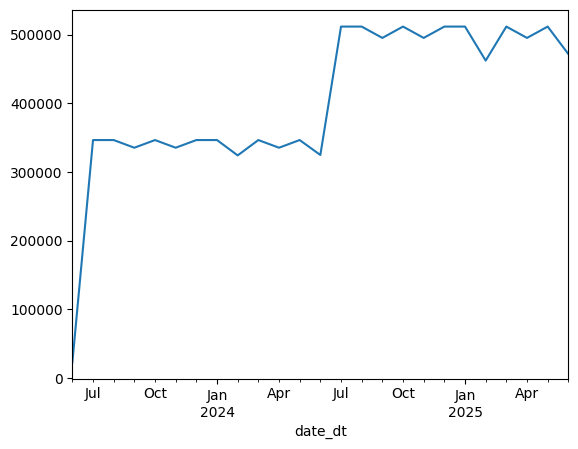

In [15]:
#Time range
cal_df["date_dt"] = pd.to_datetime(cal_df["date"])
cal_df["date_dt"].dt.to_period('M').value_counts().sort_index().plot(kind='line')

In [16]:
# See the shape of the datafram
cal_df.shape[0]

10101939

In [17]:
# Jump in counts for 2024-07, are there duplicates?
dropped_dups = cal_df.drop_duplicates()

In [18]:
dropped_dups.shape[0]

10101939

In [19]:
print("No duplicates found as counts the same")

No duplicates found as counts the same


### 1.1.3 - Price Distribution

Let's see the distribution of the prices (agnostic of a given date)

First we'll need to convert the price, which is currently a string, into a number using some string formatting and a change of type

In [20]:
# Turn price string into a number
cal_df["price_num"] = cal_df["price"].str.replace("$","")
cal_df["price_num"] = cal_df["price_num"].str.replace(",","")
cal_df["price_num"] = cal_df["price_num"].astype(float)

<Axes: xlabel='price_num', ylabel='Count'>

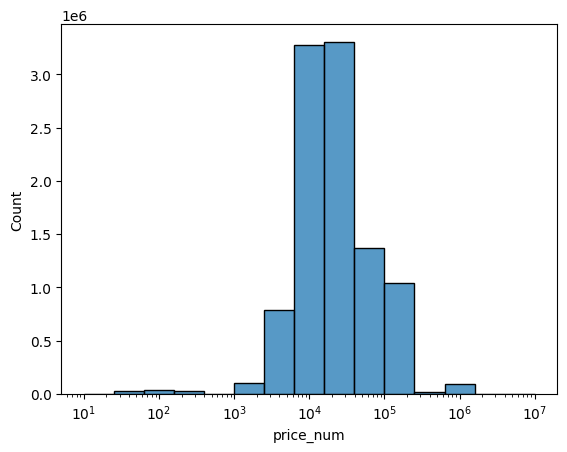

In [21]:
# Plot distribution (use log scale due to wide variation of values)
sns.histplot(data=cal_df,x="price_num",log_scale=True,bins=15)

In [22]:
print("The price distribution when logged seems to be a normal-ish distribution, this may be useful to consider later for modelling!")

The price distribution when logged seems to be a normal-ish distribution, this may be useful to consider later for modelling!


In [23]:
# How many prices are null?
cal_df["price"].isna().mean()

np.float64(0.0)

In [24]:
print("The price column is complete")

The price column is complete


### 1.1.4 - Average Prices Over Time

In 1.1.3 we ignored differences in price over time, let's now look at how the price changes over time and understand if there are any trends of note. We should aim for this to be a log scale again as we saw this best reflected the distribution of prices.

In [25]:
def average_x_time_plot(df, datefield, x, show_percentiles=False, percentile=0.95, group_var=None, log_scale=True):
    """
    Plots the average of a specified column (`x`) over time, with options for percentile bounds 
    and grouping by an additional variable.

    Parameters:
    ----------
    df : pandas.DataFrame
        The input DataFrame containing the data to be plotted.
    datefield : str
        The name of the column representing dates.
    x : str
        The column for which averages are computed and plotted.
    show_percentiles : bool, optional, default=False
        Whether to display percentile bounds on the plot. 
        If True, shaded areas showing percentile bounds are added.
    percentile : float, optional, default=0.95
        The desired percentile range to display if `show_percentiles` is True. 
        For example, 0.95 corresponds to a 95% percentile range.
    group_var : str or None, optional, default=None
        An optional column for grouping the data. Separate lines and percentile bounds are plotted 
        for each unique value in this column if provided.
    log_scale : bool, optional, default=True
        Whether to apply a natural logarithm transformation to the averages and bounds 
        before plotting.

    Returns:
    -------
    None
        The function generates and displays the plot.

    Notes:
    ------
    - If `log_scale` is True, the y-axis will represent the log-transformed values of `x`.
    - When `show_percentiles` is True and `group_var` is provided, separate shaded areas 
      representing the percentile range are plotted for each group.
    - The function uses Seaborn for line plotting and Matplotlib for additional styling.

    Example:
    --------
    average_x_time_plot(
        df=my_data, 
        datefield="date", 
        x="value", 
        show_percentiles=True, 
        percentile=0.9, 
        group_var="category", 
        log_scale=False
    )
    """

    # Copy dataframe to avoid making changes
    work_df = df.copy(deep=False)

    # Convert data column to DT format
    work_df[datefield] = pd.to_datetime(work_df[datefield])

    # Set grouping variables depending on inputs
    if group_var == None:
        group_fields = datefield
    else:
        group_fields = [datefield,group_var]

    # Get the summary stats depending on whether upper or lower bounds were wanted
    if show_percentiles:
        perc = 1-percentile
        summary_stats = work_df.groupby(group_fields)[x].agg(avg='mean',lower_bound=lambda x: x.quantile(perc/2),
    upper_bound=lambda x: x.quantile(1-perc/2)).reset_index()
    else:
        summary_stats = work_df.groupby(group_fields)[x].agg(avg='mean').reset_index()

    # Create necessary transformed variables depending on log_scale argument 
    if log_scale:
        summary_stats[f"log_{x}"] = np.log(summary_stats['avg'])
        if show_percentiles:
            summary_stats['log_lower_bound'] = np.log(summary_stats['lower_bound'])
            summary_stats['log_upper_bound'] = np.log(summary_stats['upper_bound'])

    # Create plot
    plt.figure(figsize=(12, 6))

    # Create a palette to keep colouring of bounds consistent with the line plot
    sns_palette = sns.color_palette(n_colors=summary_stats[group_var].nunique() if group_var else 1)

    # Plot lineplot of date against (log) of average x over time
    sns.lineplot(data=summary_stats, x=summary_stats[datefield],y=f"log_{x}" if log_scale else 'avg',hue=group_var, linewidth=2,palette=sns_palette)

    # Create bound plots if requested
    if show_percentiles and group_var:
        for color, (group, group_data) in zip(sns_palette, summary_stats.groupby(group_var)):
            plt.fill_between(
                group_data[datefield],
                group_data['log_lower_bound'] if log_scale else group_data['lower_bound'],
                group_data['log_upper_bound'] if log_scale else group_data['upper_bound'],
                alpha=0.2,
                color=color,
                label=f'{group} {100 * percentile}% Percentile Range'
            )

    elif show_percentiles:  # For no group_var, single fill_between
        plt.fill_between(
            summary_stats[datefield],
            summary_stats['log_lower_bound'] if log_scale else summary_stats['lower_bound'],
            summary_stats['log_upper_bound'] if log_scale else summary_stats['upper_bound'],
            alpha=0.3,
            color=sns_palette[0],
            label=f'{100 * percentile}% Percentile Range'
        )
    
    plt.xlabel('Date')
    plt.ylabel(f'Log ')
    if show_percentiles:
        plt.title(f'Average {'Log ' if log_scale else ""}{x.capitalize()} Over Time with {100*percentile}% Percentile Bounds')
    else:
        plt.title(f'Average {'Log ' if log_scale else ""}{x.capitalize()} Over Time')
    plt.legend()
    plt.show()

/tmp/ipykernel_2540/797688634.py:86: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=summary_stats, x=summary_stats[datefield],y=f"log_{x}" if log_scale else 'avg',hue=group_var, linewidth=2,palette=sns_palette)


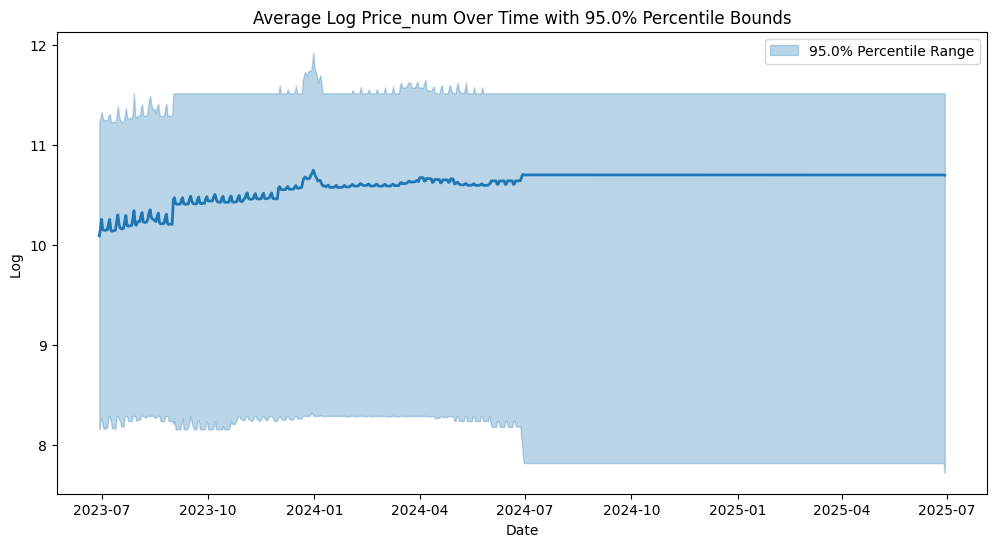

In [26]:
# Plot average log price over time
average_x_time_plot(cal_df,"date","price_num",show_percentiles=True)

In [27]:
print("Huge variability in the price at a given time as indicated by the percentiles, bear in mind a each increase in the y axis is roughly a factor of 2.7x increase in the price (e), clearly there is far more to the price than just the date.")

Huge variability in the price at a given time as indicated by the percentiles, bear in mind a each increase in the y axis is roughly a factor of 2.7x increase in the price (e), clearly there is far more to the price than just the date.


#### 1.1.4.A - Availability & Price Over Time

Let's look at how different types of availability change over time regarding price

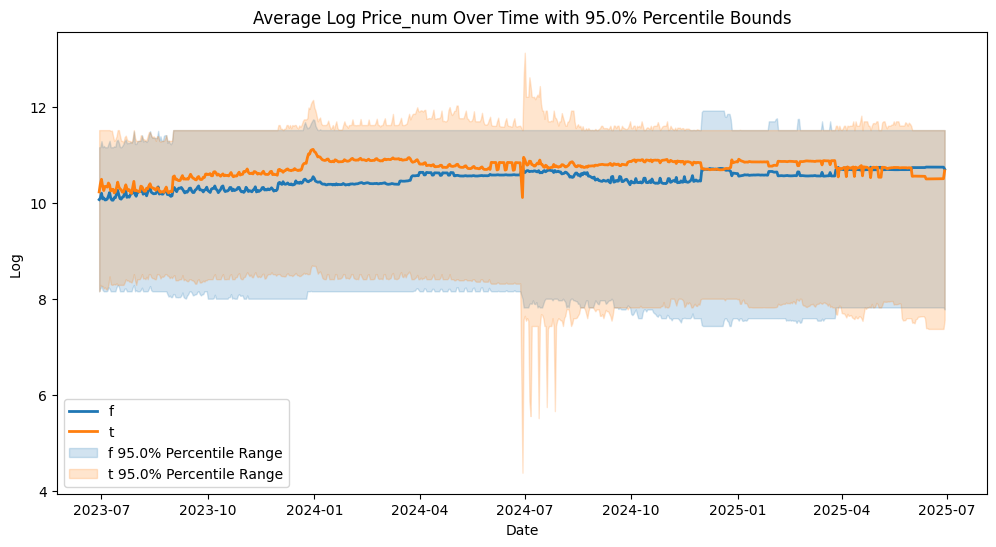

In [28]:
# Look at availability for price 
average_x_time_plot(cal_df,"date","price_num",show_percentiles=True,group_var="available")

In [29]:
print("Doesn't seem to make a huge difference, although unoccupied properties tend to be priced lower")

Doesn't seem to make a huge difference, although unoccupied properties tend to be priced lower


#### 1.1.4.B - Maximum Nights & Price Over Time

Let's look at how the maximum nights affects the price over time

In [30]:
# Look at maximum nights for price, we can split into two groups 
plot_1_df = cal_df[cal_df["maximum_nights"] <= 31]
plot_2_df = cal_df[~(cal_df["maximum_nights"] <= 31)]

/tmp/ipykernel_2540/2620749242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_1_df['maximum_nights_group'] = pd.qcut(plot_1_df['maximum_nights'], q=4,duplicates="drop")
/tmp/ipykernel_2540/797688634.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = work_df.groupby(group_fields)[x].agg(avg='mean').reset_index()


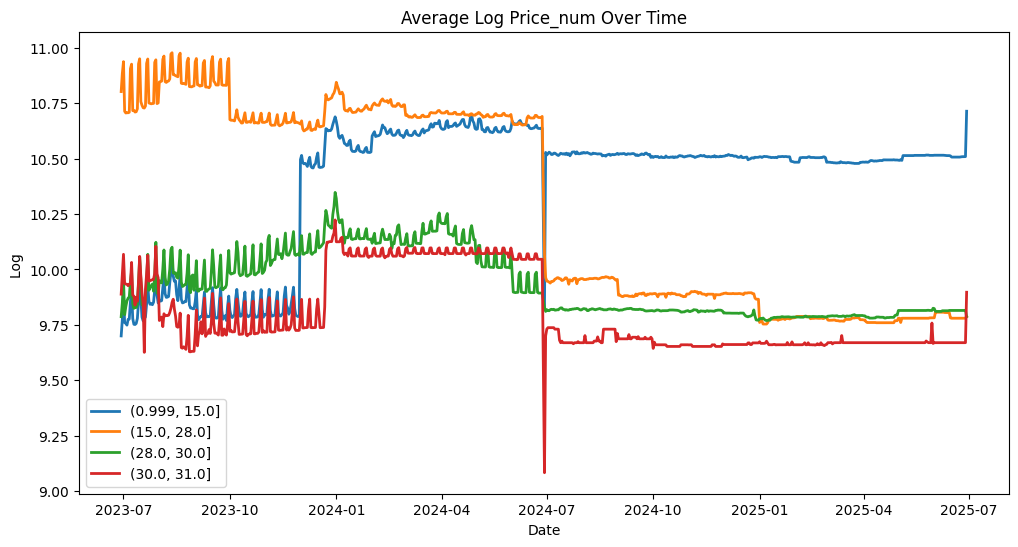

In [31]:
# Split into groups of roughly equal sizes and plot
plot_1_df['maximum_nights_group'] = pd.qcut(plot_1_df['maximum_nights'], q=4,duplicates="drop")
average_x_time_plot(plot_1_df,"date","price_num",show_percentiles=False,group_var="maximum_nights_group")

In [32]:
print("Seems that smaller maximum stays are generally more expensive, while maximum stays after a certain point are more comparable. Huge drop and rebound in 2024-07 may correspond to the large depreciation of the Yen (-8% agains the dollar) which occurred early July")

Seems that smaller maximum stays are generally more expensive, while maximum stays after a certain point are more comparable. Huge drop and rebound in 2024-07 may correspond to the large depreciation of the Yen (-8% agains the dollar) which occurred early July


/tmp/ipykernel_2540/3433462947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_2_df['maximum_nights_group'] = pd.qcut(plot_2_df['maximum_nights'], q=5,duplicates="drop")
/tmp/ipykernel_2540/797688634.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = work_df.groupby(group_fields)[x].agg(avg='mean').reset_index()


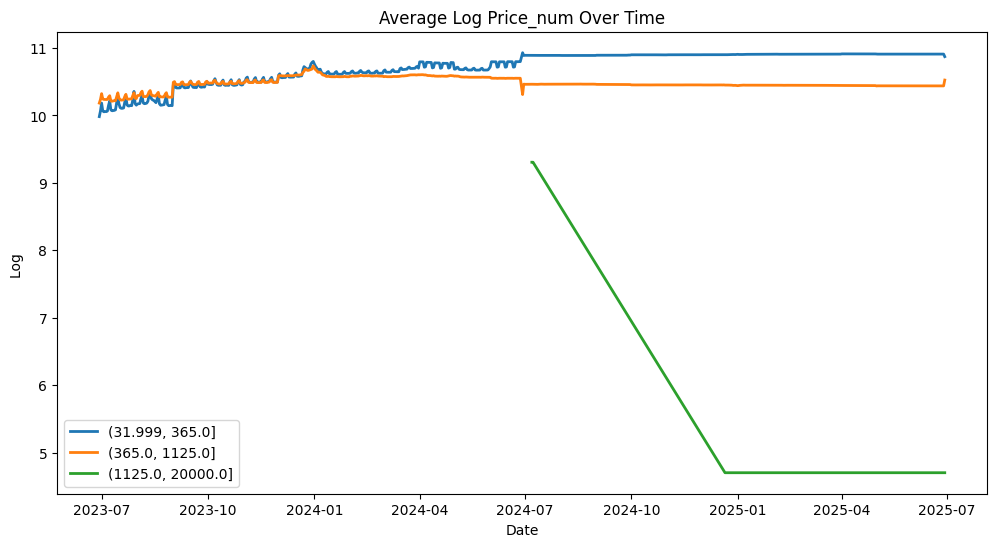

In [33]:
# Do the same for maximum nights over 31 days
plot_2_df['maximum_nights_group'] = pd.qcut(plot_2_df['maximum_nights'], q=5,duplicates="drop")
average_x_time_plot(plot_2_df,"date","price_num",show_percentiles=False,group_var="maximum_nights_group")

In [34]:
print("Properties with a likely placeholder maximum stay seem to have a precipitous decline for projected prices")

Properties with a likely placeholder maximum stay seem to have a precipitous decline for projected prices


In [35]:
cal_df.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights', 'date_dt', 'price_num'],
      dtype='object')

#### 1.1.4.C Minimum Nights

Let's see how price changes with different groups of minimun nights

/tmp/ipykernel_2540/1980759731.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_1_df['minimum_nights_group'] = pd.qcut(plot_1_df['minimum_nights'], q=3,duplicates="drop")
/tmp/ipykernel_2540/797688634.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = work_df.groupby(group_fields)[x].agg(avg='mean').reset_index()


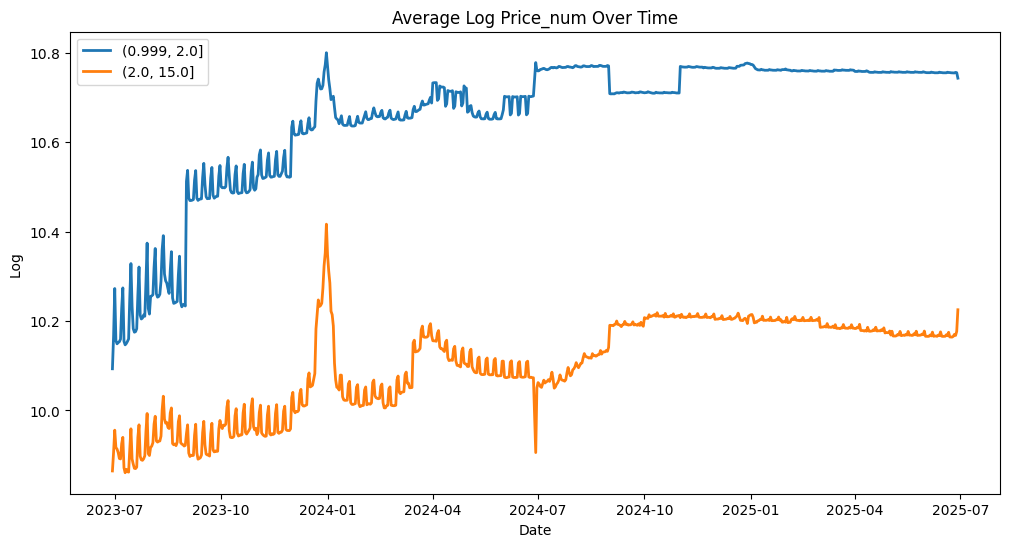

In [36]:
# Focus more on shorter nights
plot_1_df = cal_df[cal_df["minimum_nights"] <= 15]
plot_1_df['minimum_nights_group'] = pd.qcut(plot_1_df['minimum_nights'], q=3,duplicates="drop")
average_x_time_plot(plot_1_df,"date","price_num",show_percentiles=False,group_var="minimum_nights_group")

In [37]:
print("Seems to be a difference but not huge in size")

Seems to be a difference but not huge in size


/tmp/ipykernel_2540/3876419914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_2_df['minimum_nights_group'] = pd.qcut(plot_2_df['minimum_nights'], q=3,duplicates="drop")
/tmp/ipykernel_2540/797688634.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = work_df.groupby(group_fields)[x].agg(avg='mean').reset_index()


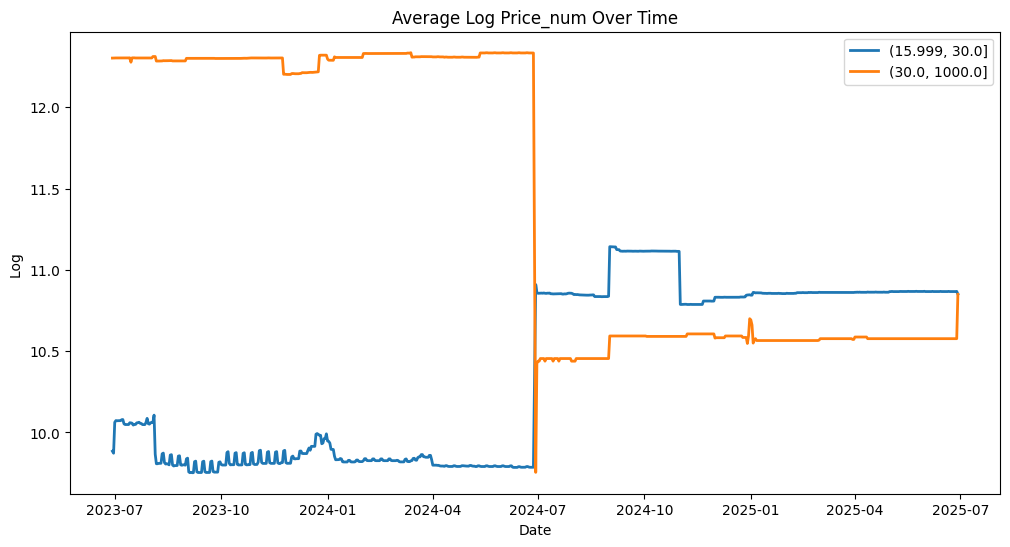

In [38]:
# Now look at the opposite groups
plot_2_df = cal_df[~(cal_df["minimum_nights"] <= 15)]
plot_2_df['minimum_nights_group'] = pd.qcut(plot_2_df['minimum_nights'], q=3,duplicates="drop")
average_x_time_plot(plot_2_df,"date","price_num",show_percentiles=False,group_var="minimum_nights_group")

In [39]:
print("Seems to be a huge difference for before 07")

Seems to be a huge difference for before 07


In [40]:
# Maybe this is driven by a paucity of counts? Let's check

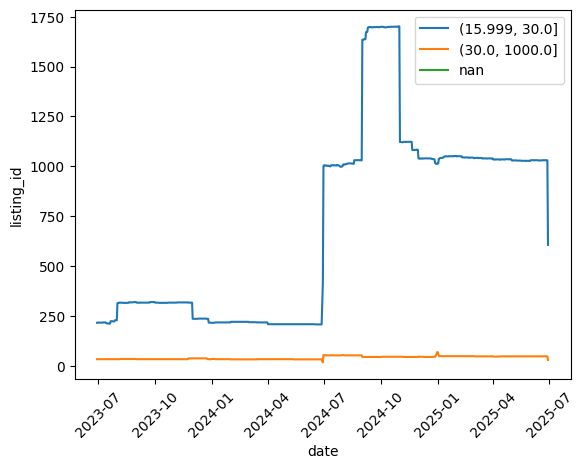

In [41]:
for minimum_nights_group in plot_2_df["minimum_nights_group"].unique():
    plot_3_df = plot_2_df[plot_2_df["minimum_nights_group"]==minimum_nights_group].groupby(by="date",as_index=False).agg("count")
    plot_3_df["date"] = pd.to_datetime(plot_3_df["date"])
    sns.lineplot(data=plot_3_df,x="date",y="listing_id",label=minimum_nights_group)
    plt.xticks(rotation=45)
plt.show()

In [42]:
print("Seems to confirm that there was a larg jump in properties in 2024-07 which will likely have changed the average price, explaining the change.")

Seems to confirm that there was a larg jump in properties in 2024-07 which will likely have changed the average price, explaining the change.


### 1.1.5 - Adjusted Price vs Standard Price

Here we want to see what the role of the adjusted price is, what does it mean in relation to the price column, first we can check if it's redundant by seeing if it matches the price column completely

In [43]:
# Fetch columns from original dataframe
check_df = cal_df[["price","adjusted_price"]]

In [44]:
# Create a column checking if they are equal
check_df["checking_column"] = check_df["price"] == check_df["adjusted_price"]

/tmp/ipykernel_2540/555683085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_df["checking_column"] = check_df["price"] == check_df["adjusted_price"]


In [45]:
check_df["checking_column"].mean()

np.float64(0.3576426268263944)

In [46]:
print("~35% of the price - adjusted_price pairs match in a given row")

~35% of the price - adjusted_price pairs match in a given row


In [47]:
len(check_df[(check_df["checking_column"] == False) & (check_df["adjusted_price"].isna() == False)])/len(cal_df)*100

4.608313314899249

In [48]:
print("Of that 35%, 4% (absolute terms) are when there is actually an adjusted price and it isn't just null")

Of that 35%, 4% (absolute terms) are when there is actually an adjusted price and it isn't just null


In [49]:
print("""Given only in 4% of cases the adjusted prices differs asides from being null and further that there is no information regarding its meaning in the AirBnb provided data dictionary (https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?gid=150111846#gid=150111846).

It seems reasonable to drop this column as it cannot be interpreted and has a very low non-duplicated completeness""")

Given only in 4% of cases the adjusted prices differs asides from being null and further that there is no information regarding its meaning in the AirBnb provided data dictionary (https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?gid=150111846#gid=150111846).

It seems reasonable to drop this column as it cannot be interpreted and has a very low non-duplicated completeness


In [50]:
cal_df = cal_df[[col for col in cal_df.columns if col != "adjusted_price"]]

### 1.1.6 - NaNs

Here we're looking to identify nulls in our data as a pre-step for data processing later on

In [51]:
# Asides from adjusted price, how many nulls do we find in our other non-primary key features
cal_df.isna().mean().reset_index()

,index,0
0,listing_id,0.000000
1,date,0.000000
2,available,0.000000
3,price,0.000000
4,minimum_nights,0.000033
5,maximum_nights,0.000033
6,date_dt,0.000000
7,price_num,0.000000


In [52]:
print("The data is highly complete for all fields!")

The data is highly complete for all fields!


### 1.1.7 - Summary

In summary we found the following:

- The calendar dataframe is unique to both the listing id (property) and the date, there were no duplications of listing id and date
- The price is stored as a string and needed to be converted to a number
- There is a range of dates in the dataframe from Jul-23 to Jul-25 (projected)
- The adjusted price column is largely inexplicable and given its high null rate/duplication rate with the price column it makes sense to drop it from further consideration
- Price does seem to be influenced by other features such as the minimum/maximum nights as well as room availability however individually these features do not seem to have high predictive power
- The data is largely complete with only ~0.33% null rate for the minimum/maximum nights data
- There is a large jump in listing id counts in july 2024, this likely reflects the introduction of the 2024 airbnb dataset which contains more listings than the 2023 one

## 1.2 - Listings

In [53]:
# View columns in the listings dataframe which provides more information on individual hosts 
list_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

### 1.2.1 - Data Structure

Now we want to look at our listing dataset. This dataset contains a lot of essential information regarding the property itself, this will prove invaluable for all 4 of our business questions. Given the size of this dataframe we will need to be on the look out for redundant or difficult-to-use/irrelevant columns.

In [54]:
list_df.head(1)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20230629055629,2023-06-29,city scrape,Rental unit in Sumida · ★4.78 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.21


In [55]:
print("Seems to be unique to id and last_scraped level")

Seems to be unique to id and last_scraped level


In [56]:
# Test this with an assertion
assert list_df[["id","last_scraped"]].shape[0] == list_df[["id","last_scraped"]].drop_duplicates().shape[0]

In [57]:
# Do many ids have multiple scrapes?
scrape_counts = list_df[["id","last_scraped"]].groupby(by="id",as_index=False).agg("count").rename(columns={"last_scraped" : "scrape_count"})

display(scrape_counts["scrape_count"].value_counts())

scrape_count
1    10163
2     8766
Name: count, dtype: int64

In [58]:
print("Most ids have been scraped only 1, this seems to correspond with the large jump in ids we say in the 2024 dataset, what are the dates for those only scraped once?")

Most ids have been scraped only 1, this seems to correspond with the large jump in ids we say in the 2024 dataset, what are the dates for those only scraped once?


In [59]:
list_df["last_scraped"].value_counts()

last_scraped
2023-06-29    11177
2024-06-30     9984
2024-06-29     6534
Name: count, dtype: int64

In [60]:
pd.merge(left=scrape_counts[scrape_counts["scrape_count"] ==1],right=list_df[["id","last_scraped"]],how="inner",on="id")["last_scraped"].value_counts()

last_scraped
2024-06-30    4586
2024-06-29    3166
2023-06-29    2411
Name: count, dtype: int64

In [61]:
print("Seems there was a big intake in 2024 July (just before)")

Seems there was a big intake in 2024 July (just before)


### 1.2.1 - Time Structure in Dataframe

In [62]:
# Get a list of ids
test_ids = list_df["id"].head().values

In [63]:
# See how things change over time
list_df[list_df["id"].isin(test_ids)].sort_values(by="id")

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20230629055629,2023-06-29,city scrape,Rental unit in Sumida · ★4.78 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.21
11177,197677,https://www.airbnb.com/rooms/197677,20240629155511,2024-06-30,city scrape,Oshiage Holiday Apartment,NaN,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,...,4.83,4.54,4.79,M130003350,f,1,1,0,0,1.13
11178,776070,https://www.airbnb.com/rooms/776070,20240629155511,2024-06-29,city scrape,Kero-kero house room 1,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,801494,...,4.98,4.84,4.92,M130000243,f,1,0,1,0,1.81
1,776070,https://www.airbnb.com/rooms/776070,20230629055629,2023-06-29,city scrape,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,801494,...,4.98,4.83,4.91,NaN,f,1,0,1,0,1.89
11179,905944,https://www.airbnb.com/rooms/905944,20240629155511,2024-06-30,city scrape,4F - Near Shinjuku & Shibuya,NEWLY RENOVATED property entirely for you & yo...,Hatagaya is a great neighborhood located 4 min...,https://a0.muscache.com/pictures/miso/Hosting-...,4847803,...,4.91,4.79,4.79,Hotels and Inns Business Act | 渋谷区保健所長 | 31渋健生...,t,6,6,0,0,1.60
2,905944,https://www.airbnb.com/rooms/905944,20230629055629,2023-06-29,city scrape,Rental unit in Shibuya · ★4.76 · 2 bedrooms · ...,NEWLY RENOVATED property entirely for you & yo...,Hatagaya is a great neighborhood located 4 min...,https://a0.muscache.com/pictures/miso/Hosting-...,4847803,...,4.90,4.77,4.77,Hotels and Inns Business Act | 渋谷区保健所長 | 31渋健生...,t,5,5,0,0,1.49
3,1016831,https://www.airbnb.com/rooms/1016831,20230629055629,2023-06-29,city scrape,Home in Setagaya · ★4.94 · 1 bedroom · 2 beds ...,"Hi there, I am Wakana and I live with my two f...",The location is walkable distance to famous Sh...,https://a0.muscache.com/pictures/airflow/Hosti...,5596383,...,4.98,4.92,4.89,NaN,f,1,0,1,0,1.96
11180,1016831,https://www.airbnb.com/rooms/1016831,20240629155511,2024-06-29,city scrape,5 mins Shibuya Cat modern sunny Shimokita,"Hi there, I am Wakana and I live with my two f...",The location is walkable distance to famous Sh...,https://a0.muscache.com/pictures/airflow/Hosti...,5596383,...,4.98,4.92,4.90,M130001107,f,2,1,1,0,1.96
4,1196177,https://www.airbnb.com/rooms/1196177,20230629055629,2023-06-29,city scrape,Home in 足立区 · ★4.71 · 1 bedroom · 1.5 shared b...,Ｓtay with host.We can help your travel.<br />B...,There are shopping mall near Senjuohashi stati...,https://a0.muscache.com/pictures/72890882/05ec...,5686404,...,4.88,4.67,4.75,NaN,f,1,0,1,0,0.79
11181,1196177,https://www.airbnb.com/rooms/1196177,20240629155511,2024-06-29,city scrape,Stay with host Cozy private room Senju area,Ｓtay with host.We can help your travel.<br />B...,There are shopping mall near Senjuohashi stati...,https://a0.muscache.com/pictures/72890882/05ec...,5686404,...,4.91,4.73,4.80,M130007760,f,1,0,1,0,0.91


In [64]:
# How many listings have data for both years?
list_df["id"].value_counts().reset_index()["count"].value_counts(normalize=True)

count
1    0.536901
2    0.463099
Name: proportion, dtype: float64

In [65]:
print("Around 50% only appear for one year")

Around 50% only appear for one year


In [66]:
# Create average price table 
average_prices = cal_df[["listing_id","price_num"]].groupby(by="listing_id",as_index=False).agg("mean")

### 1.2.2 - Slimming Down the Data

Although the CRISPR-DM process recommends engaging in data cleaning after data analysis, given there are 75 columns we will first want to identify the columns which are relevant for analysis and those which do not contain  useful business information to the questions at hand. This will make performing the analysis much more targeted in scope and give us more space for detailed views. 

To avoid clogging the notebook with sub-headings, I will have one large cell below in which I go through each column, explain the data it provides and make a decision as to whether it is needed or not. I will justify each decision. I will then subset the dataframe to slim it down and begin the CRISPR-DM data understanding process for this table.

In [67]:
list(list_df.columns)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30

In [68]:
columns_to_drop = ["listing_url","scrape_id","source","name","description","picture_url","host_name","host_about","host_thumbnail_url","host_picture_url","host_url"]

In [69]:
explanations = ["Provides a link to the AirBnB site which isnt' needed or relevant for our purposes", 
                "This is the time stamp at which the listing was scraped but given we have the last_scraped field this is unnecessarily granular and we don't need it",
               "Just provides the way in which it was scraped, only has 2 values and isn't very important",
               "The name is just the name of the property as it's free text it makes it hard to encode for a basic model or analyse in any way, I am not qualified for NLP",
               "The description similarly is free text and therefore outside the scope of my ability to analyse or bring to a basic model",
               "This just provides a url to the photo of a AirBnb which is not useful for our project",
               "This is the first name of the host, as it functions as free text I will not be using this feature",
                "This column is a free text description provided by the host about themselves, as it is free text is not in scope",
                "This is just a url to the host thumbnail and therefore not useful",
                "This is just a url to the host's profile picture and therefore not useful",
                "This is just a url to the host and therefore not useful, espcially when we have host_id instead"
               ]

In [70]:
for i in range(0,len(columns_to_drop)):
    print(f"""Column to Drop : {columns_to_drop[i]}
    Justification: {explanations[i]}
    
    """)

Column to Drop : listing_url
    Justification: Provides a link to the AirBnB site which isnt' needed or relevant for our purposes
    
    
Column to Drop : scrape_id
    Justification: This is the time stamp at which the listing was scraped but given we have the last_scraped field this is unnecessarily granular and we don't need it
    
    
Column to Drop : source
    Justification: Just provides the way in which it was scraped, only has 2 values and isn't very important
    
    
Column to Drop : name
    Justification: The name is just the name of the property as it's free text it makes it hard to encode for a basic model or analyse in any way, I am not qualified for NLP
    
    
Column to Drop : description
    Justification: The description similarly is free text and therefore outside the scope of my ability to analyse or bring to a basic model
    
    
Column to Drop : picture_url
    Justification: This just provides a url to the photo of a AirBnb which is not useful for our

In [71]:
list_df = list_df[[col for col in list_df.columns if col not in columns_to_drop]]

### 1.2.3 - Data Types

Here we get an overview of the data types in our data to help structure subsequent analysis

In [72]:
# Get types of the columns in the DataFrame
types_df = list_df.dtypes.reset_index()
types_df.columns = ["col","type"]

In [73]:
# Find numeric fields
types_df["is_numeric"] = types_df["type"].astype(str).apply(lambda x : True if x in ["int64","float64"] else False)

#### A - Numeric Types

In [74]:
# Isolate numeric fields
num_df = types_df[types_df["is_numeric"] == True]

In [75]:
num_df

,col,type,is_numeric
0,id,int64,True
3,host_id,int64,True
11,host_listings_count,int64,True
12,host_total_listings_count,int64,True
18,neighbourhood_group_cleansed,float64,True
19,latitude,float64,True
20,longitude,float64,True
23,accommodates,int64,True
24,bathrooms,float64,True
26,bedrooms,float64,True


In [76]:
print("Using the AirBnB data dictionary we have can provide some definitions for these columns where their function is not clear")

Using the AirBnB data dictionary we have can provide some definitions for these columns where their function is not clear


I will summarise some of the data fields together and provide an explanation based on the AirBnB data dictionary:

1. The 'minimum_minimum_nights' etc. data fields are in the following format {measure}_{variable} which are calculated over the time period since the last scrape, it shows say in the example of minimum_minimum_nights the smallest 'minimum nights' that was listed for the property. The average simarly is an average over the max/min nights over the same period.

2. Calendar updated is when the host updated their calendar

3. The availability_x data is the number of days in the future from the point of scraping that the propert was available i.e. availability_60 says out of the next 60 days how many days are available for the listing to be booked

4. Number of reviews 'ltm' means the number of reviews in the last 12 months, while l30d means the number in the last 30 days

5. The reviews_scores_x are the average scores for x review metric (AirBnb customers rate across many metrics)

6. calculated_host... are calculated variables by AirBnb showing the number of homes/private rooms/shared rooms that the host possesses (asides from the individual listing) the average number of reviews per month the listing has since it's been in operation

#### B - Categorical Types

In [77]:
# Isolate cat types
cat_df = types_df[types_df["is_numeric"] == False]

In [78]:
cat_df

,col,type,is_numeric
1,last_scraped,object,False
2,neighborhood_overview,object,False
4,host_since,object,False
5,host_location,object,False
6,host_response_time,object,False
7,host_response_rate,object,False
8,host_acceptance_rate,object,False
9,host_is_superhost,object,False
10,host_neighbourhood,object,False
13,host_verifications,object,False


In [79]:
print("These are self explanatory, I will add a note that the response rate and acceptance rate are both numbers just brought in as strings. The price here is daily avg price in local currency.")

These are self explanatory, I will add a note that the response rate and acceptance rate are both numbers just brought in as strings. The price here is daily avg price in local currency.


### 1.2.4 - Null Data

Here I want to look at null data and see the amount of null data present in our DataFrame

In [80]:
types_df["na_rate"] = types_df["col"].apply(lambda x : list_df[x].isna().mean())

In [81]:
types_df.sort_values(by="na_rate",ascending=False)

,col,type,is_numeric,na_rate
18,neighbourhood_group_cleansed,float64,True,1.000000
38,calendar_updated,float64,True,1.000000
10,host_neighbourhood,object,False,0.566420
24,bathrooms,float64,True,0.461961
16,neighbourhood,object,False,0.334898
...,...,...,...,...
58,instant_bookable,object,False,0.000000
59,calculated_host_listings_count,int64,True,0.000000
60,calculated_host_listings_count_entire_homes,int64,True,0.000000
61,calculated_host_listings_count_private_rooms,int64,True,0.000000


In [82]:
print("We can see that neighbourhood_group_cleansed and calendar_updated are both completely null and therefore we should drop them as they contain no information")

We can see that neighbourhood_group_cleansed and calendar_updated are both completely null and therefore we should drop them as they contain no information


In [83]:
# Drop from list_df and the type_df
list_df = list_df[[col for col in list_df.columns if col not in ["neighbourhood_group_cleansed","calendar_updated"]]]
types_df = types_df[~(types_df["col"].isin(["neighbourhood_group_cleansed","calendar_updated"]))]

In [84]:
types_df.sort_values(by="na_rate",ascending=False)

,col,type,is_numeric,na_rate
10,host_neighbourhood,object,False,0.566420
24,bathrooms,float64,True,0.461961
16,neighbourhood,object,False,0.334898
2,neighborhood_overview,object,False,0.334898
5,host_location,object,False,0.310778
...,...,...,...,...
58,instant_bookable,object,False,0.000000
59,calculated_host_listings_count,int64,True,0.000000
60,calculated_host_listings_count_entire_homes,int64,True,0.000000
61,calculated_host_listings_count_private_rooms,int64,True,0.000000


In [85]:
print("The null rates here are not very high so we can proceed with these columns, in the case a column is null and is unique to the listing level then it can only be guessed, whereas if the host information is missing for a listing but is present for another listing by the same host then we can reliably impute that missing value and potentially reduce the NA rate")

The null rates here are not very high so we can proceed with these columns, in the case a column is null and is unique to the listing level then it can only be guessed, whereas if the host information is missing for a listing but is present for another listing by the same host then we can reliably impute that missing value and potentially reduce the NA rate


### 1.2.5 - Potentially Imputing Host Data

Here we want to establish whether we can potentially impute host data by using other listings of the same host

In [86]:
# Host related info has host in the name
host_cols = [col for col in list_df.columns if "host" in col]

In [87]:
# Get the types for these columns
host_types = types_df[types_df["col"].isin(host_cols)]

In [88]:
host_types.sort_values(by="na_rate",ascending=False)

,col,type,is_numeric,na_rate
10,host_neighbourhood,object,False,0.566420
5,host_location,object,False,0.310778
9,host_is_superhost,object,False,0.083192
7,host_response_rate,object,False,0.045171
6,host_response_time,object,False,0.045171
8,host_acceptance_rate,object,False,0.034988
3,host_id,int64,True,0.000000
4,host_since,object,False,0.000000
11,host_listings_count,int64,True,0.000000
12,host_total_listings_count,int64,True,0.000000


In [89]:
# Filter for those missing values
host_pot_imput = host_types[host_types["na_rate"] > 0]

In [90]:
host_pot_imput

,col,type,is_numeric,na_rate
5,host_location,object,False,0.310778
6,host_response_time,object,False,0.045171
7,host_response_rate,object,False,0.045171
8,host_acceptance_rate,object,False,0.034988
9,host_is_superhost,object,False,0.083192
10,host_neighbourhood,object,False,0.566420


In [91]:
# We can check the host_level na rate by seeing the number of hosts with no information
imput_cols = host_pot_imput["col"].to_list()

In [92]:
def calculate_nan_rate(dataframe, columns, host_id_col='host_id', listing_id_col='id'):
    """
    Calculate the na rate for specified columns at the host level.

    This function groups the data by 'host_id' and calculates the proportion of missing values 
    (NaNs) for each column within the group. It then averages the na rate across all hosts
    to provide a summary.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the data.
    columns (list of str): A list of column names to calculate the NaN rates for.
    host_id_col (str): The name of the column identifying the hosts (default: 'host_id').
    listing_id_col (str): The name of the column identifying the listings (default: 'id').

    Returns:
    dict: A dictionary where keys are column names and values are the average NaN rates 
          across hosts for those columns.
    """
    results = {}
    
    for col in columns:
        # Aggregate to check if data is missing for all listings under the same host
        host_na_rate = (
            dataframe.groupby(host_id_col)[col]
            .apply(lambda x: x.isna().mean())  # Calculate na rate per host
        )
        results[col] = host_na_rate.mean()  # Average na rate across all hosts
    
    return results

In [93]:
nan_rates = calculate_nan_rate(list_df, imput_cols)

# na rates at the host level for the selected columns
for field, rate in nan_rates.items():
    print(f"{field}: {rate}")

host_location: 0.3879459605338327
host_response_time: 0.07068766446770601
host_response_rate: 0.07068766446770601
host_acceptance_rate: 0.052159478861859655
host_is_superhost: 0.07268485668100264
host_neighbourhood: 0.6869235358870635


In [94]:
host_pot_imput

,col,type,is_numeric,na_rate
5,host_location,object,False,0.310778
6,host_response_time,object,False,0.045171
7,host_response_rate,object,False,0.045171
8,host_acceptance_rate,object,False,0.034988
9,host_is_superhost,object,False,0.083192
10,host_neighbourhood,object,False,0.566420


In [95]:
print("We can impute some data for the host fields given the na rates differ")

We can impute some data for the host fields given the na rates differ


In [96]:
def impute_host_data(dataframe, columns, host_id_col='host_id', last_scraped_col='last_scraped'):
    """
    Impute missing host data for the specified columns based on other listings for the same host.

    When imputing, if there are conflicts between values from different listings of the same host,
    the value from the listing with the most recent 'last_scraped' date is preferred.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the data.
    columns (list of str): A list of column names to impute missing values for.
    host_id_col (str): The name of the column identifying the hosts (default: 'host_id').
    last_scraped_col (str): The name of the column indicating the date of the last scrape.

    Returns:
    pd.DataFrame: A dataframe with the missing values in the specified columns imputed.
    """
    # Sort the dataframe by host_id and last_scraped (most recent first) and copy
    work_df = dataframe.sort_values(by=[host_id_col, last_scraped_col], ascending=[True, False]).copy()

    for col in columns:
        # Forward-fill and backward-fill within each group
        work_df[col] = (
            work_df.groupby(host_id_col)[col]
            .apply(lambda group: group.ffill().bfill())
            .reset_index(level=0, drop=True)  # Align index back to original
        )

    return work_df

In [97]:
list_df_imputed = impute_host_data(list_df,imput_cols)

/tmp/ipykernel_2540/3692275333.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda group: group.ffill().bfill())
/tmp/ipykernel_2540/3692275333.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda group: group.ffill().bfill())
/tmp/ipykernel_2540/3692275333.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  

In [98]:
list_df_imputed.head(1)

,id,last_scraped,neighborhood_overview,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
17576,52588660,2024-06-29,You can walk to Tamagawa Takashimaya and RISE ...,322234,2010-12-19,"Tokyo, Japan",within a few hours,100%,87%,t,...,5.0,4.78,5.0,M130030481,f,1,0,1,0,0.68


In [99]:
list_df_imputed[imput_cols].isna().mean().reset_index()

,index,0
0,host_location,0.300126
1,host_response_time,0.024373
2,host_response_rate,0.024373
3,host_acceptance_rate,0.019245
4,host_is_superhost,0.010435
5,host_neighbourhood,0.555949


In [100]:
print("We have successfully reduce the na rate for some of these fields using a justifiable imputation of data by comparing to the same host from other listings")

We have successfully reduce the na rate for some of these fields using a justifiable imputation of data by comparing to the same host from other listings


In [101]:
list_df = list_df_imputed

### 1.2.6 - Cardinality of Categorical Variables

Here I want to check that the cardinality (i.e. number of unique values) for my categorical variables is not too high and within bounds that allow it to be a useful model feature.

In [102]:
# Get number of unique values for each categorical column
cat_df["cardinality"] = cat_df["col"].apply(lambda x : list_df[x].nunique())

In [103]:
cat_df.sort_values(by="cardinality",ascending=False)

,col,type,is_numeric,cardinality
28,amenities,object,False,21806
57,license,object,False,10974
29,price,object,False,7585
2,neighborhood_overview,object,False,6315
48,first_review,object,False,2803
4,host_since,object,False,2260
49,last_review,object,False,1136
16,neighbourhood,object,False,412
5,host_location,object,False,187
8,host_acceptance_rate,object,False,74


Many of these are in an acceptable range apart from neighbourhood upwards, we should investigate these in turn

According to the AirBnB the neighbourhood field and neighbourhood overview are freetext provided by the hosts describing the neighbourhood and providing a host-written overview, accordingly since these are free text it would not be appropriate to keep these in as variables as I cannot do NLP. Luckily the neighbourhood_cleansed is produced using the lon/lat of the listing and local shapefiles describing region boundaries. Hence we can use this field as it has been produced and verfied by AirBnb. 

first_review, last_review and host_since are all dates and so we would expect a higher amount of cardinality, we may want to aggregate these to year and month level instead to reduce cardinality as it's unlikely the day itself will affect much. 

The price is stored here as a string so it is not surprising it has a high cardinality as it is actually a number.

The licence field is the number of the host's licence, given we already have the host_id and licence is unique at the host level there is no need to keep this variable. 

Amenities however may have a high cardinality on account of the way it is entered in list format, we may want to reorder the lists to be in a consistent format and recheck the cardinality

In [104]:
# Accordingly we can drop the columns as justified above
list_df = list_df[[col for col in list_df.columns if col not in ["neighbourhood","neighborhood_overview","license"]]]

In [105]:
cat_df[cat_df["col"].isin(list_df.columns)].sort_values(by="cardinality",ascending=False)

,col,type,is_numeric,cardinality
28,amenities,object,False,21806
29,price,object,False,7585
48,first_review,object,False,2803
4,host_since,object,False,2260
49,last_review,object,False,1136
5,host_location,object,False,187
8,host_acceptance_rate,object,False,74
21,property_type,object,False,65
17,neighbourhood_cleansed,object,False,49
10,host_neighbourhood,object,False,47


#### Amenities - Aside

Here we want to look at the amenities field and see ways we might be able to address its high cardinality (almost unique to listing level currently)

In [106]:
# Show amenities head 
list_df["amenities"].head()

17576    ["Bed linens", "Dining table", "Self check-in"...
7200     ["Pets allowed", "Hot water kettle", "Free dry...
20637    ["Bed linens", "Dining table", "Shared patio o...
20836    ["Bed linens", "Dining table", "Toaster", "Hea...
20837    ["Bed linens", "Dining table", "Toaster", "Hea...
Name: amenities, dtype: object

In [107]:
print("It seems that the items themselves are consistent but differently ordered")

It seems that the items themselves are consistent but differently ordered


Accordingly a sensible approach would be to get a unique list of all amenities and then create boolean columns indicating if the amenity is present or not, in addition we can make a column that contains the number of amenities, this will reduce the cardinality extensively and allow us to keep this useful information.

In [108]:
import ast
from functools import reduce

# Safely parse strings to lists
parsed_amenities = list_df["amenities"].apply(ast.literal_eval)  # Converts string to list

# Use reduce with lambda to find unique amenities
unique_amenities = reduce(lambda acc, x: acc.update(x) or acc, parsed_amenities, set())

# Convert to a sorted list for readability
unique_amenities_list = sorted(unique_amenities)

print(f"Total unique amenities: {len(unique_amenities_list)}")


Total unique amenities: 3016


In [109]:
print("We managed to reduce the amount but it seems there is some freetext involved as we have high cardinality and also Japanese characters NB I can't print it as it's too large, perhaps we can exclude amenties that only appear once")

We managed to reduce the amount but it seems there is some freetext involved as we have high cardinality and also Japanese characters NB I can't print it as it's too large, perhaps we can exclude amenties that only appear once


In [110]:
from collections import Counter

# Safely parse strings to lists if they are stored as strings
parsed_amenities = list_df["amenities"].apply(ast.literal_eval)

# Flatten the list of amenities and count occurrences
amenities_counter = Counter([amenity for sublist in parsed_amenities for amenity in sublist])

# Filter out amenities with a count of 1
filtered_amenities = {amenity: count for amenity, count in amenities_counter.items() if count > 1}

# Convert to a sorted list of (amenity, count) tuples for better readability
sorted_filtered_amenities = sorted(filtered_amenities.items(), key=lambda x: x[1], reverse=True)

# Display the results
print(f"Number of amenities appearing more than once: {len(sorted_filtered_amenities)}")

amenity_count = len(sorted_filtered_amenities)

Number of amenities appearing more than once: 1854


In [111]:
print(f"This cardinality is still far too high, we need to reduce this until we get to a reasonable number, our dataframe only has {len(list_df)} rows and we cannot break the rank rule for modelling")

This cardinality is still far too high, we need to reduce this until we get to a reasonable number, our dataframe only has 27695 rows and we cannot break the rank rule for modelling


In [112]:
print("Let's reduce this to 70-100")

Let's reduce this to 70-100


In [113]:
ticker = 10000
amenity_count=1
while amenity_count<100:
    # Safely parse strings to lists if they are stored as strings
    parsed_amenities = list_df["amenities"].apply(ast.literal_eval)
    
    # Flatten the list of amenities and count occurrences
    amenities_counter = Counter([amenity for sublist in parsed_amenities for amenity in sublist])
    
    # Filter out amenities with a count of 1
    filtered_amenities = {amenity: count for amenity, count in amenities_counter.items() if count > ticker}
    
    # Convert to a sorted list of (amenity, count) tuples for better readability
    sorted_filtered_amenities = sorted(filtered_amenities.items(), key=lambda x: x[1], reverse=True)

    amenity_count = len(sorted_filtered_amenities)
    
    # Display the results
    print(f"Number of amenities appearing more than once: {amenity_count} for count threshold of {ticker}")

    ticker-=1000

Number of amenities appearing more than once: 33 for count threshold of 10000
Number of amenities appearing more than once: 36 for count threshold of 9000
Number of amenities appearing more than once: 38 for count threshold of 8000
Number of amenities appearing more than once: 40 for count threshold of 7000
Number of amenities appearing more than once: 42 for count threshold of 6000
Number of amenities appearing more than once: 43 for count threshold of 5000
Number of amenities appearing more than once: 49 for count threshold of 4000
Number of amenities appearing more than once: 58 for count threshold of 3000
Number of amenities appearing more than once: 65 for count threshold of 2000
Number of amenities appearing more than once: 80 for count threshold of 1000
Number of amenities appearing more than once: 3016 for count threshold of 0


In [114]:
print("We can now set a threshold at 1000 to get 80 amenity columns as booleans")

We can now set a threshold at 1000 to get 80 amenity columns as booleans


In [115]:
import warnings
warnings.filterwarnings("ignore")

# Safely parse strings to lists if they are stored as strings
parsed_amenities = list_df["amenities"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Flatten the list of amenities and count occurrences
amenities_counter = Counter([amenity for sublist in parsed_amenities for amenity in sublist])

# Filter amenities with a count >= 80
popular_amenities = [amenity for amenity, count in amenities_counter.items() if count >= 1000]

# Create boolean columns for each popular amenity
for amenity in popular_amenities:
    column_name = f"has_amenity_{amenity.replace(' ', '_').lower()}"  # Create valid column names
    list_df[column_name] = parsed_amenities.apply(lambda x: amenity in x)

In [116]:
list_df[[col for col in list_df.columns if "amenity" in col]].head()

,has_amenity_bed_linens,has_amenity_dining_table,has_amenity_self_check-in,has_amenity_bathtub,has_amenity_toaster,has_amenity_hot_water,has_amenity_heating,has_amenity_hangers,has_amenity_body_soap,has_amenity_bidet,...,has_amenity_books_and_reading_material,has_amenity_free_washer_–_in_building,has_amenity_pocket_wifi,has_amenity_keypad,has_amenity_smart_lock,has_amenity_children’s_dinnerware,has_amenity_central_air_conditioning,has_amenity_cleaning_available_during_stay,has_amenity_paid_parking_on_premises,has_amenity_safe
17576,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
7200,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
20637,True,True,False,False,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
20836,True,True,False,False,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
20837,True,True,False,False,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


In [117]:
print("Finally we can make a column for the overall number of amenities")

Finally we can make a column for the overall number of amenities


In [118]:
list_df["amenity_count"] = list_df[[col for col in list_df.columns if "amenity" in col]].sum(axis=1)

In [119]:
# Now we have converted the amenity column to a more usable feature we can drop it 
list_df.drop(columns=["amenities"],inplace=True)

### 1.2.7 - Side Note

Given the huge numper of columns in this dataframe I cannot possibly do an extensive EDA on each column asides from the checks I have already done (I have a full time job 🙃), nonetheless I will do preliminary analysis for features I deem interesting or that will be related to the questions we wish to solve. 

### 1.2.8 - Review Data

Here I want to look at the review data to see how it's distributed and how it relates to price

<Axes: >

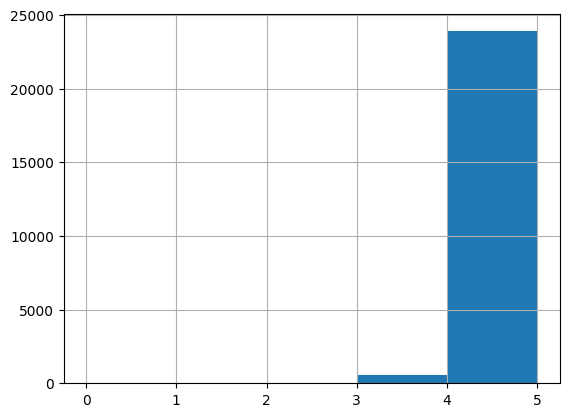

In [120]:
# Plot histogram for review rating
list_df["review_scores_rating"].hist(bins=5)

<Axes: >

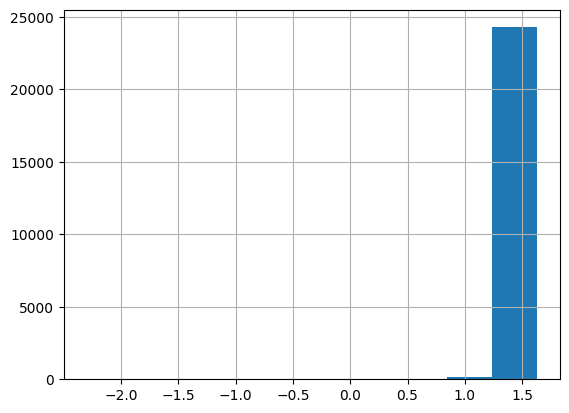

In [121]:
# Take log to spread out distribution a bit more, add offset for reviews of 0
np.log(list_df["review_scores_rating"]+0.1).hist(bins=10)

In [122]:
print("Even with a log distribution to flatten the distribution somewhat, there is an extremely high bias to good reviews")

Even with a log distribution to flatten the distribution somewhat, there is an extremely high bias to good reviews


In [123]:
# What % of reviews are null? 
list_df["review_scores_rating"].isna().mean()

np.float64(0.1145694168622495)

In [124]:
# Compare reviews and prices
stars_and_prices = pd.merge(left=average_prices,right=list_df[["id","review_scores_rating"]].rename(columns={"id":"listing_id"}),how="inner",on="listing_id")

<Axes: xlabel='review_scores_rating', ylabel='price_num'>

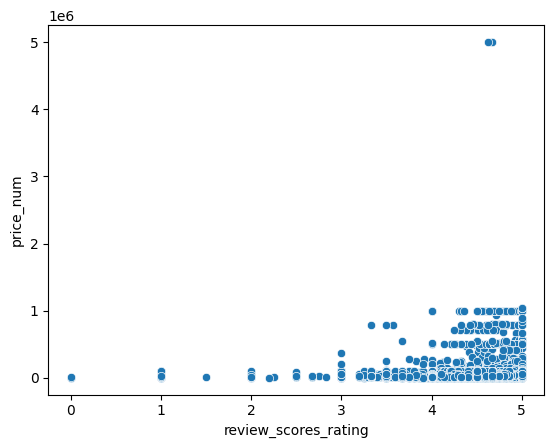

In [125]:
sns.scatterplot(data=stars_and_prices,x="review_scores_rating",y="price_num")

<Axes: xlabel='review_scores_rating', ylabel='price_num'>

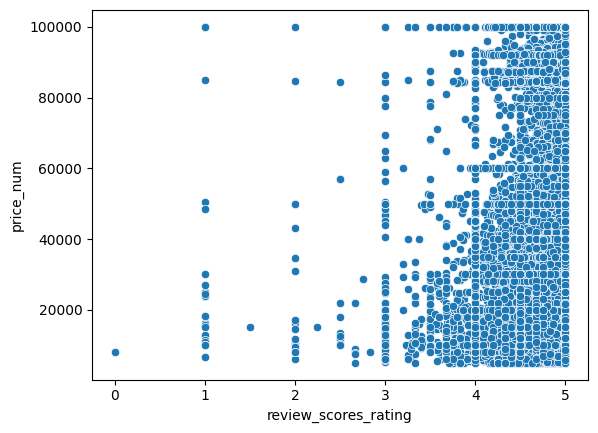

In [126]:
# Let's remove outliers on price

lower_quantile = 0.05
upper_quantile = 0.95

# Calculate the lower and upper bounds
price_lower = stars_and_prices['price_num'].quantile(lower_quantile)
price_upper = stars_and_prices['price_num'].quantile(upper_quantile)

# Filter the data to remove outliers
filtered_data = stars_and_prices[
    (stars_and_prices['price_num'] >= price_lower) &
    (stars_and_prices['price_num'] <= price_upper)
]


sns.scatterplot(data=filtered_data,x="review_scores_rating",y="price_num")


In [127]:
print("Still quite a lot of variability, hard to spot a trend from the visualisation")

Still quite a lot of variability, hard to spot a trend from the visualisation


### 1.2.9- Room Type

Here I want to do some high level views at the room types for the listings

In [128]:
roomgen_and_price = pd.merge(left=average_prices,right=list_df[["id","room_type"]].rename(columns={"id":"listing_id"}),how="inner",on="listing_id")

<Axes: xlabel='room_type', ylabel='price_num'>

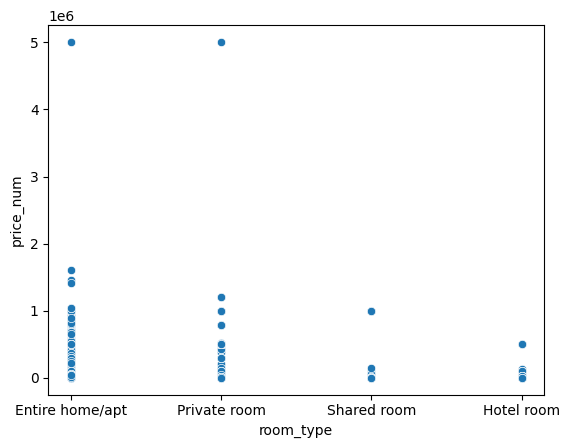

In [129]:
sns.scatterplot(data=roomgen_and_price,x="room_type",y="price_num")

<Axes: xlabel='room_type', ylabel='price_num'>

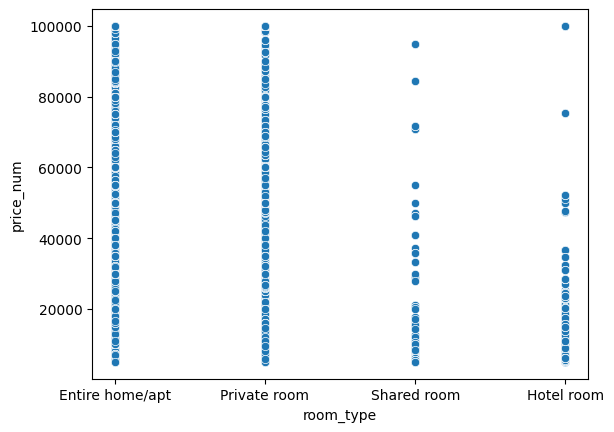

In [130]:
# Let's remove outliers on price

lower_quantile = 0.05
upper_quantile = 0.95

# Calculate the lower and upper bounds
price_lower = roomgen_and_price['price_num'].quantile(lower_quantile)
price_upper = roomgen_and_price['price_num'].quantile(upper_quantile)

# Filter the data to remove outliers
filtered_data = roomgen_and_price[
    (roomgen_and_price['price_num'] >= price_lower) &
    (roomgen_and_price['price_num'] <= price_upper)
]


sns.scatterplot(data=filtered_data,x="room_type",y="price_num")


In [131]:
print("Different distributions for each, seems to suggest shared rooms and hotel rooms are generally cheaper though")

Different distributions for each, seems to suggest shared rooms and hotel rooms are generally cheaper though


### 1.2.10 - Number of Rooms

Here I want to do some high level views of the number of rooms as it relates to prices and listings

In [132]:
# Compare averages and bedrooms
price_room_df = pd.merge(left=average_prices,right=list_df[["id","bedrooms"]].rename(columns={"id":"listing_id"}),how="inner",on="listing_id")

In [133]:
# Set percentage (bottom and top quartlies to visualise)
perc=0.05

# Perform aggregation for the bedroom level
price_by_room_df = price_room_df[["bedrooms","price_num"]].groupby(by="bedrooms",as_index=True)["price_num"].agg(avg_price="mean",lower_bound=lambda x: x.quantile(perc/2),
    upper_bound=lambda x: x.quantile(1-perc/2)).reset_index()

In [134]:
price_by_room_df.head()

,bedrooms,avg_price,lower_bound,upper_bound
0,0.0,59918.766249,4972.500000,109784.942466
1,1.0,39281.276267,3551.563699,100000.000000
2,2.0,40852.241533,8052.739726,113569.917808
3,3.0,48524.552416,10793.972603,161929.691781
4,4.0,55465.194148,13085.154110,194227.397260


<Axes: xlabel='bedrooms', ylabel='avg_price'>

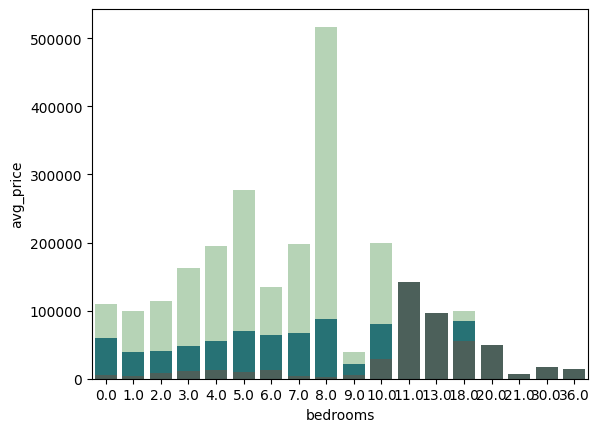

In [135]:
# Plot average prices with quartiles for listings with different no. beds
sns.barplot(data=price_by_room_df.sort_values(by="bedrooms",ascending=True),x="bedrooms",y="avg_price")
sns.barplot(data=price_by_room_df.sort_values(by="bedrooms",ascending=True),x="bedrooms",y="lower_bound",color='r',alpha=0.3)
sns.barplot(data=price_by_room_df.sort_values(by="bedrooms",ascending=True),x="bedrooms",y="upper_bound",color='g',alpha=0.3)

In [136]:
print("Bedrooms seems to have some correlation to price for less than 5 bedrooms, perhaps 6 bedrooms represent hostels etc.")

Bedrooms seems to have some correlation to price for less than 5 bedrooms, perhaps 6 bedrooms represent hostels etc.


In [137]:
list_df["bedrooms"].value_counts().reset_index().sort_values(by="bedrooms",ascending=True)

,bedrooms,count
3,0.0,1019
0,1.0,17508
1,2.0,3989
2,3.0,1890
4,4.0,732
5,5.0,209
6,6.0,69
7,7.0,31
8,8.0,24
10,9.0,6


### 1.2.11 - Neighbourhood

Here I want to look at the 'neighbourhood_cleansed' feature as a precursor to question 1

In [138]:
# How many in the cleansed column?
list_df["neighbourhood_cleansed"].nunique()

49

In [139]:
# Get average prices and neighbourhoods for listing 
neighbourhood_price_df = pd.merge(left=average_prices,right=list_df[["id","neighbourhood_cleansed"]].rename(columns={"id":"listing_id"}),how="inner",on="listing_id")

In [140]:
# Group by neighbourhood
price_by_neigh_df = neighbourhood_price_df.groupby("neighbourhood_cleansed",as_index=False).agg("mean")

In [141]:
def neighbourhood_name_tider(neighbourhood):
    '''Function to tidy up neighbourhood names for plots'''
    for redundant_text in [' Ku',' Mura',' Shi']:
        if redundant_text in neighbourhood:
            neighbourhood=neighbourhood.replace(redundant_text,"")
    return neighbourhood

In [142]:
# Tidy up names for a plot
price_by_neigh_df["tidier_neighbourhood_name"] = price_by_neigh_df["neighbourhood_cleansed"].apply(neighbourhood_name_tider)

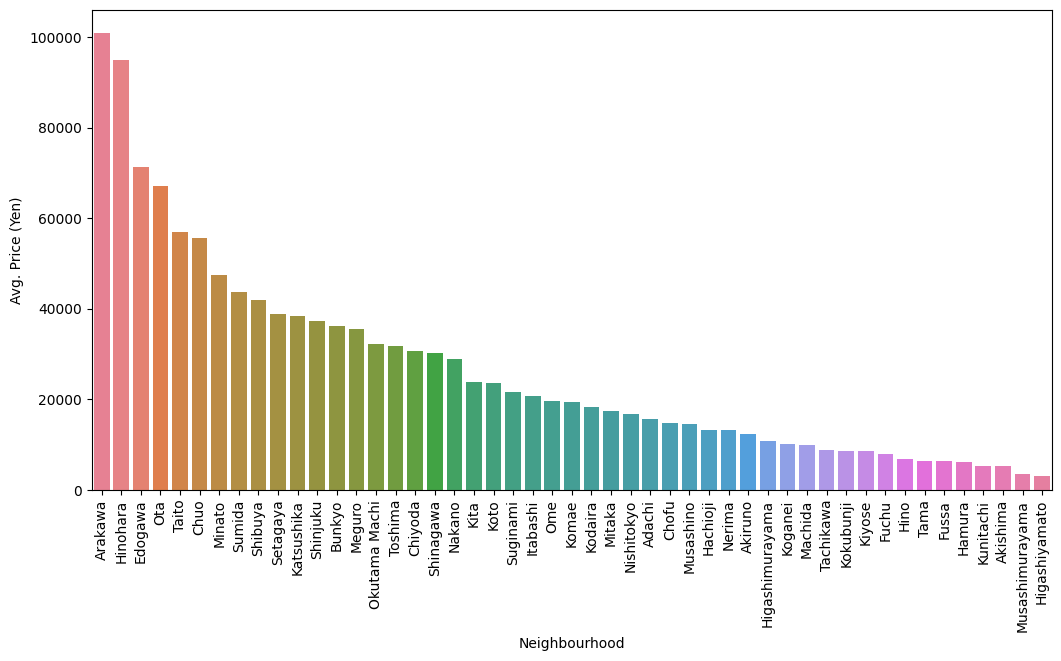

In [143]:
plt.figure(figsize=(12, 8))  # Increase the figure size for more white space
sns.barplot(
    data=price_by_neigh_df.sort_values(by="price_num", ascending=False),
    x="tidier_neighbourhood_name",
    y="price_num",
    hue="tidier_neighbourhood_name"
)
plt.xticks(rotation=90)
plt.ylabel("Avg. Price (Yen)")
plt.xlabel("Neighbourhood")

# Adjust subplot to add more white space around the plot
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)

# Save the plot
plt.savefig(f"{get_root_dir()}/data/image_1.png")
plt.show()

In [144]:
price_by_neigh_df[["tidier_neighbourhood_name","price_num"]].sort_values(by="price_num",ascending=False)

,tidier_neighbourhood_name,price_num
3,Arakawa,100976.315925
16,Hinohara,95000.000000
8,Edogawa,71322.342832
38,Ota,67086.206757
46,Taito,57052.298425
7,Chuo,55711.954748
29,Minato,47502.923549
44,Sumida,43693.547430
40,Shibuya,41930.298148
39,Setagaya,38914.844438


In [145]:
print("Neighbourhood seems to have a big impact on price")

Neighbourhood seems to have a big impact on price


In [146]:
# Tidy the neighbourhood names
neighbourhood_price_df["tidied_neighbourhood"] = neighbourhood_price_df["neighbourhood_cleansed"].apply(neighbourhood_name_tider)

In [147]:
# Let's get 10 neighbourhoods at random
random_10_neighbourhoods = neighbourhood_price_df["tidied_neighbourhood"].sample(n=10,random_state=42,replace=False).to_list()

In [148]:
# Let's make a plot for the top 4 of these (for Medium)
plot_df = neighbourhood_price_df[neighbourhood_price_df["tidied_neighbourhood"].isin(random_10_neighbourhoods)]

In [149]:
# Log price to make the distribution more visible
plot_df["log_price"] = np.log(plot_df["price_num"])

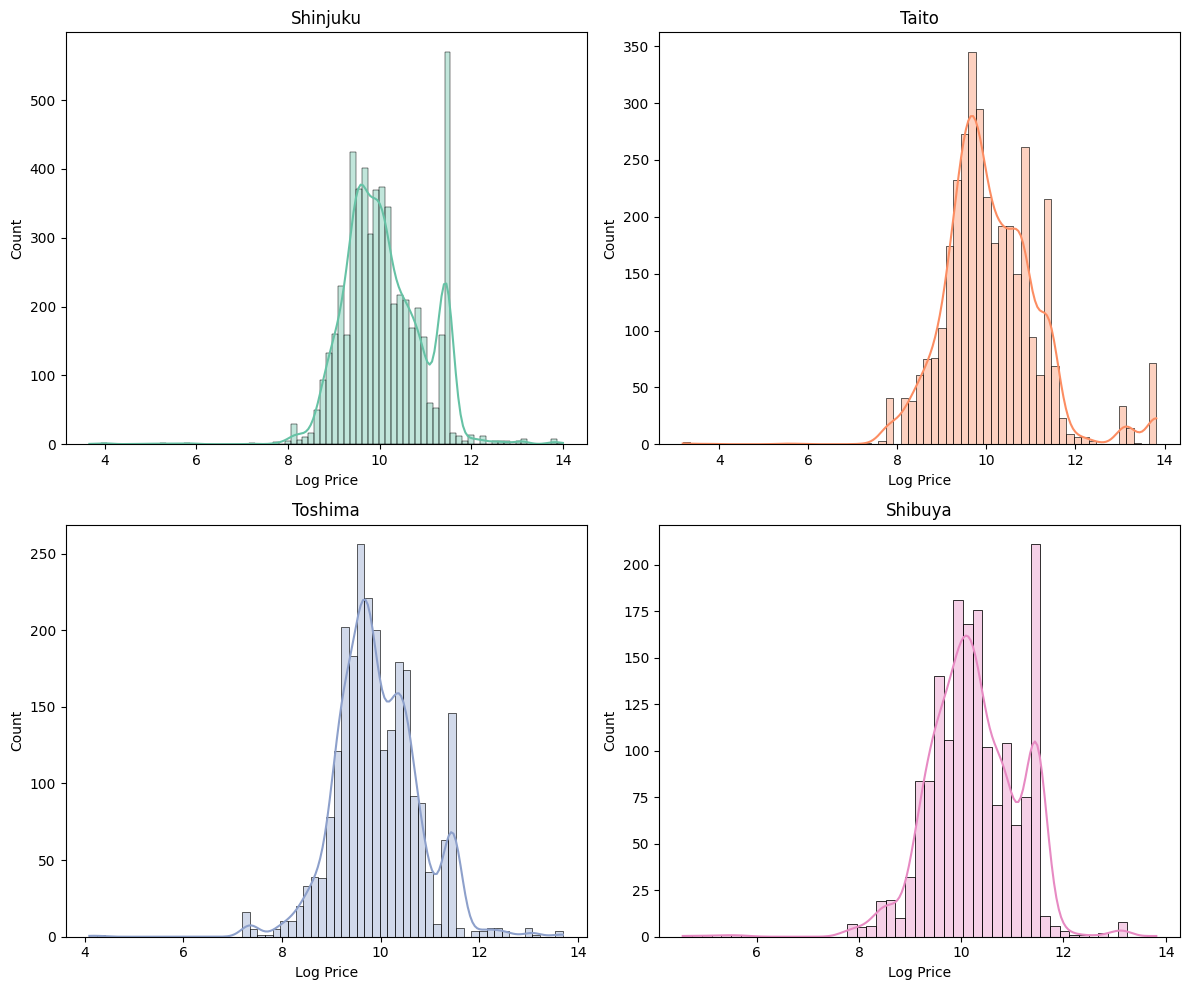

In [150]:
# Get the top 4 neighborhoods with the most counts
top_neighbourhoods = plot_df['tidied_neighbourhood'].value_counts().head(4).index


# Filter data for only the top 4 neighborhoods
filtered_df = plot_df[plot_df['tidied_neighbourhood'].isin(top_neighbourhoods)]

top_neighbourhood_names = filtered_df['tidied_neighbourhood'].unique()
# Create a grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid

# Make palette
palette = sns.color_palette("Set2", n_colors=4)

# Iterate through each neighborhood and corresponding subplot
for ax, (neighbourhood, color) in zip(axes.flatten(), zip(top_neighbourhoods, palette)):
    sns.histplot(
        data=filtered_df[filtered_df['tidied_neighbourhood'] == neighbourhood],
        x="log_price",
        alpha=0.4,
        kde=True,
        color=color,  # Assign color from the palette
        ax=ax
    )
    ax.set_title(f"{neighbourhood}")
    ax.set_xlabel("Log Price")
    ax.set_ylabel("Count")

# Adjust layout for better spacing and save
plt.tight_layout()
plt.savefig(f"{get_root_dir()}/data/image2.png")
plt.show()

## 1.3 - Cherry Blossom Data

Here I want to look at the Cherry blossom data and the behvaiour of the calendar dataframe around the blooming period

### 1.3.1 - High Level View

Let's first get a high level view of the dataframes

In [151]:
first_bloom.head()

,site_name,currently_being_observed,1953,1954,1955,1956,1957,1958,1959,1960,...,2016,2017,2018,2019,2020,2021,2022,2023,30_year_average_1981-2010,notes
0,Wakkanai,True,1953-05-21,1954-05-17,1955-05-17,1956-05-12,1957-05-18,1958-05-23,1959-05-03,1960-05-19,...,2016-05-13,2017-05-09,2018-05-12,2019-05-07,2020-05-10,2021-05-08,2022-05-06,2023-05-03,5 13,Sargent cherry (Prunus sargentii)
1,Rumoi,False,1953-05-08,1954-05-11,1955-05-13,1956-05-08,1957-05-10,1958-05-12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Sargent cherry (Prunus sargentii)
2,Asahikawa,True,1953-05-11,1954-05-13,1955-05-09,1956-05-07,1957-05-09,1958-05-10,1959-05-08,1960-05-13,...,2016-05-03,2017-05-03,2018-04-30,2019-05-01,2020-05-03,2021-04-29,2022-04-26,2023-04-25,5 4,Sargent cherry (Prunus sargentii)
3,Abashiri,True,1953-05-24,1954-05-16,1955-05-18,1956-05-09,NaN,NaN,1959-05-03,NaN,...,2016-05-08,2017-05-05,2018-05-02,2019-05-05,2020-05-07,2021-05-06,2022-04-27,2023-04-28,5 10,Sargent cherry (Prunus sargentii)
4,Sapporo,True,1953-05-07,1954-05-04,1955-05-11,1956-05-04,1957-05-09,NaN,1959-05-05,1960-05-05,...,2016-04-25,2017-04-28,2018-04-26,2019-04-24,2020-04-30,2021-04-22,2022-04-23,2023-04-15,5 1,NaN


In [152]:
full_bloom.head()

,site_name,currently_being_observed,1953,1954,1955,1956,1957,1958,1959,1960,...,2016,2017,2018,2019,2020,2021,2022,2023,30_year_average_1981-2010,notes
0,Wakkanai,True,1953-05-30,1954-05-27,1955-05-23,1956-05-14,1957-05-22,1958-05-25,1959-05-12,1960-05-24,...,2016-05-15,2017-05-11,2018-05-15,2019-05-09,2020-05-12,2021-05-11,2022-05-09,2023-05-05,5 16,Sargent cherry (Prunus sargentii)
1,Rumoi,False,1953-05-13,1954-05-17,1955-05-16,1956-05-14,1957-05-14,1958-05-16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Sargent cherry (Prunus sargentii)
2,Asahikawa,True,1953-05-16,1954-05-18,1955-05-14,1956-05-13,1957-05-14,1958-05-15,1959-05-13,1960-05-16,...,2016-05-04,2017-05-05,2018-05-01,2019-05-04,2020-05-04,2021-05-03,2022-04-28,2023-04-28,5 7,Sargent cherry (Prunus sargentii)
3,Abashiri,True,1953-05-26,1954-05-19,1955-05-20,1956-05-13,NaN,NaN,1959-05-07,NaN,...,2016-05-10,2017-05-07,2018-05-06,2019-05-07,2020-05-09,2021-05-07,2022-04-30,2023-05-01,5 13,Sargent cherry (Prunus sargentii)
4,Sapporo,True,1953-05-14,1954-05-08,1955-05-16,1956-05-09,1957-05-13,NaN,1959-05-10,1960-05-09,...,2016-05-01,2017-05-03,2018-04-29,2019-04-29,2020-05-02,2021-04-27,2022-04-25,2023-04-21,5 6,NaN


In [153]:
# Locations covered
first_bloom["site_name"].unique()

array(['Wakkanai', 'Rumoi', 'Asahikawa', 'Abashiri', 'Sapporo',
       'Iwamizawa', 'Obihiro', 'Kushiro', 'Nemuro', 'Muroran', 'Urakawa',
       'Esashi', 'Hakodate', 'Kutchan', 'Monbetsu', 'Hiroo', 'Shinjo',
       'Aomori', 'Hachinohe', 'Akita', 'Morioka', 'Miyako', 'Sakata',
       'Yamagata', 'Sendai', 'Fukushima', 'Shirakawa', 'Onahama',
       'Wajima', 'Aikawa', 'Niigata', 'Kanazawa', 'Toyama', 'Nagano',
       'Takada', 'Utsunomiya', 'Fukui', 'Takayama', 'Matsumoto',
       'Maebashi', 'Kumagaya', 'Mito', 'Tsuruga', 'Gifu', 'Nagoya',
       'Iida', 'Kofu', 'Choshi', 'Tsu', 'Hamamatsu', 'Shizuoka',
       'Tokyo Japan', 'Owashi', 'Yokohama', 'Tateyama', 'Oshima',
       'Miyakejima', 'Hachijojima', 'Saigo', 'Matsue', 'Yonago',
       'Tottori', 'Toyooka', 'Maizuru', 'Hamada', 'Kyoto', 'Hikone',
       'Hiroshima', 'Okayama', 'Kobe', 'Osaka', 'Sumoto', 'Wakayama',
       'Shio Misaki', 'Nara', 'Matsuyama', 'Takamatsu', 'Uwajima',
       'Kochi', 'Tokushima', 'Shimonoseki', 'Mikih

In [154]:
## Compare to neighbourhoods 
neighbourhoods = list_df["neighbourhood_cleansed"].unique()
bloom_sites = first_bloom["site_name"].unique()


# Make into single strings
neighbourhoods = [neighbourhood.split()[0] for neighbourhood in list_df["neighbourhood_cleansed"].unique()]
bloom_sites = [site.split()[0] for site in first_bloom["site_name"].unique()]

# Find crossover 
intersection = set(neighbourhoods).intersection(set(bloom_sites))
print(intersection)

set()


In [155]:
# Only the 'Tokyo Japan' area covers our AirBnB data
tokyo_first_bloom = first_bloom[first_bloom["site_name"] == "Tokyo Japan"]
tokyo_full_bloom = full_bloom[full_bloom["site_name"] == "Tokyo Japan"]

In [156]:
tokyo_first_bloom

,site_name,currently_being_observed,1953,1954,1955,1956,1957,1958,1959,1960,...,2016,2017,2018,2019,2020,2021,2022,2023,30_year_average_1981-2010,notes
51,Tokyo Japan,True,1953-03-26,1954-03-26,1955-03-24,1956-03-26,1957-04-02,1958-03-30,1959-03-24,1960-03-23,...,2016-03-21,2017-03-21,2018-03-17,2019-03-21,2020-03-14,2021-03-14,2022-03-20,2023-03-14,3 24,NaN


In [157]:
tokyo_full_bloom

,site_name,currently_being_observed,1953,1954,1955,1956,1957,1958,1959,1960,...,2016,2017,2018,2019,2020,2021,2022,2023,30_year_average_1981-2010,notes
51,Tokyo Japan,True,1953-04-05,1954-04-01,1955-04-05,1956-04-08,1957-04-10,1958-04-06,1959-04-05,1960-04-01,...,2016-03-31,2017-04-02,2018-03-24,2019-03-27,2020-03-22,2021-03-22,2022-03-27,2023-03-22,3 31,NaN


In [158]:
print("Does not cover out date range, can we find the dates elswhere?")

Does not cover out date range, can we find the dates elswhere?


In [159]:
print("""Using :{https://www.jrailpass.com/blog/japan-cherry-blossom-forecast}

first bloom is 2024-03-29 and full bloom is 2024-04-04
""")

Using :{https://www.jrailpass.com/blog/japan-cherry-blossom-forecast}

first bloom is 2024-03-29 and full bloom is 2024-04-04



In [160]:
near_to_bloom_cal_df = cal_df[(pd.to_datetime(cal_df["date"]) < '2024-05-01') & (pd.to_datetime(cal_df["date"]) > '2024-02-01')]

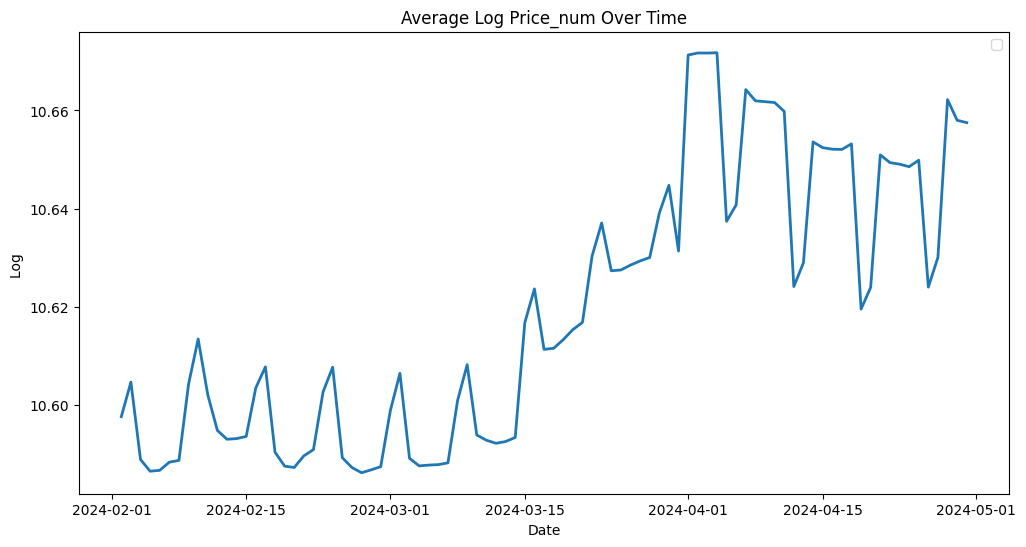

In [161]:
# Look at availability for price 
average_x_time_plot(near_to_bloom_cal_df,"date","price_num")

In [162]:
print("Seems to be a change, can we check using the Mann-Whitney U test")

Seems to be a change, can we check using the Mann-Whitney U test


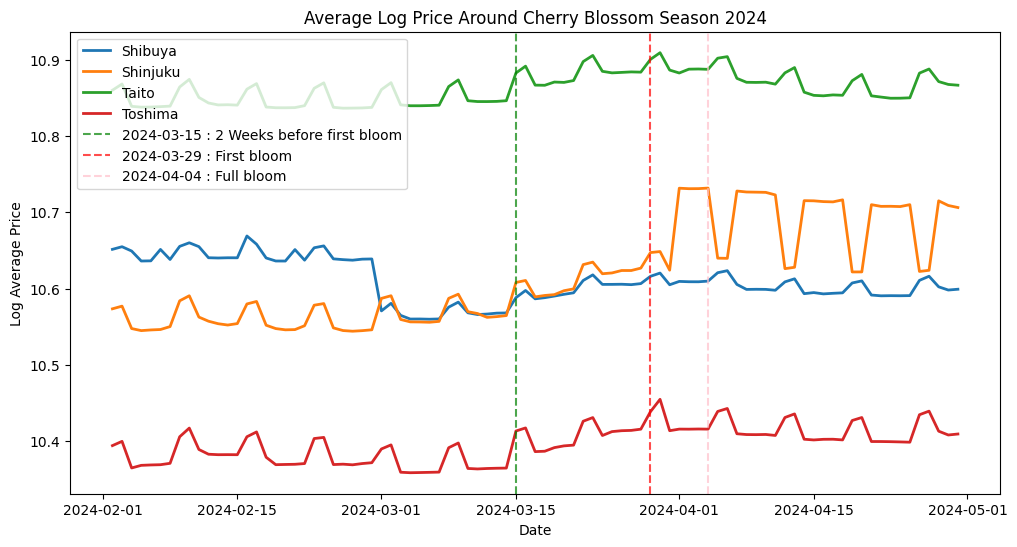

In [163]:
# Make a prettier plot for Medium

# Use logic from average x time plot function with relevant changes

# Copy dataframe to avoid making changes
work_df = near_to_bloom_cal_df.copy(deep=False)

work_df = pd.merge(left=work_df,right=list_df[["id","neighbourhood_cleansed"]].rename(columns={"id":"listing_id"}),how="inner",on="listing_id")

# Convert data column to DT format
work_df["date"] = pd.to_datetime(work_df["date"])

work_df["tidier_neighbourhood_name"] = work_df["neighbourhood_cleansed"].apply(neighbourhood_name_tider)

work_df = work_df[work_df["tidier_neighbourhood_name"].isin(top_neighbourhood_names)]

# Set grouping variables
group_fields = ["date","tidier_neighbourhood_name"]

# Get the summary stats depending on whether upper or lower bounds were wanted
summary_stats = work_df.groupby(group_fields)["price_num"].agg(avg='mean').reset_index()

# Create necessary transformed variables depending on log_scale argument 
summary_stats["log_price"] = np.log(summary_stats['avg'])


# Create plot
plt.figure(figsize=(12, 6))

# Create a palette to keep colouring of bounds consistent with the line plot
sns_palette = sns.color_palette(n_colors=summary_stats["tidier_neighbourhood_name"].nunique())

# Plot lineplot of date against (log) of average x over time
sns.lineplot(data=summary_stats, x=summary_stats["date"],y="log_price",hue="tidier_neighbourhood_name", linewidth=2,palette=sns_palette)

vline_dates = ['2024-03-15','2024-03-29','2024-04-04']
vline_colours = ['green','red','pink']
vline_labels = ['2 Weeks before first bloom','First bloom', 'Full bloom']

for index, date in enumerate(vline_dates):
    plt.axvline(pd.to_datetime(date), linestyle="--", color=vline_colours[index], alpha=0.7, label=f"{date} : {vline_labels[index]}")
    
plt.xlabel('Date')
plt.ylabel(f'Log Average Price')
plt.title(f'Average Log Price Around Cherry Blossom Season 2024')
plt.legend()
plt.savefig(f"{get_root_dir()}/data/image3.png")
plt.show()

# 2 - Answering Questions

Here we will be looking to answer our questions we had regarding the data. The questions may or may not involve modelling, in the instances where they do this has been split out using the headings feature of the notebooks.

## 2.1 - Q1

In [164]:
get_question("1")

Q1: How much do neighbourhoods affect the price of AirBnbs?


### 2.1.1 - Considering Our Variables

Here we are solely looking at neighbourhood, in this case as represented by 'neighbourhood_cleansed' and its impact on the price of AirBnB listings. We have already seen that there is a lot of variability both between neighbourhoods and within neighbourhoods in as far as price goes, however if we want to clarify more specifically the role neighbourhood plays on determing price we can assess this using a linear regression model using neighbourhood to predict price and measure the efficacy of the model by metrics such as mean average error, mean squared error and the resultant R^2 value.

As we have also seen price varies somewhat over time so we should use the average price found in the list_df dataframe.

In [165]:
# First transform the list_df price variable so it is no longer a string
list_df["price_num"] = list_df["price"].astype(str).apply(lambda x : x.replace("$","").replace(",","")).astype(float)

In [166]:
list_df["price_num"].head(1)

17576    7429.0
Name: price_num, dtype: float64

In [167]:
# Check we haven't change the na rate
assert list_df["price_num"].isna().mean() == list_df["price"].isna().mean()

In [168]:
# Variables of interest
q1_df = list_df[["neighbourhood_cleansed","price_num"]]

In [169]:
# Check if the price has any nulls
q1_df["price_num"].isna().mean()

np.float64(0.06185231991334176)

In [170]:
# Filter out nulls
q1_df = q1_df[~q1_df["price_num"].isna()]

In [171]:
# Assert nulls are gone
assert q1_df["price_num"].isna().sum() == 0

In [172]:
# Turn neighbourhood into categorical columns 
q1_df = pd.get_dummies(q1_df,columns=["neighbourhood_cleansed"],drop_first=True,dtype=int)

In [173]:
# Check if there are prices of 0
q1_df["price_num"].value_counts().reset_index().sort_values(by="price_num",ascending=True)

,price_num,count
6132,0.0,1
4641,1280.0,1
1846,1450.0,2
279,1500.0,15
267,1600.0,16
...,...,...
704,999999.0,7
1071,1000000.0,4
765,1052387.0,6
5624,1063744.0,1


In [174]:
# Drop the 0 price as it doesn't make sense and will cause an error with a log 
q1_df = q1_df[q1_df["price_num"] > 0]

In [175]:
# Set the variables 
y = np.log(q1_df["price_num"])
X = q1_df[[col for col in q1_df.columns if col != "price_num"]]

In [176]:
print(len(y),len(X))

25981 25981


In [177]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [178]:
# Fit model
neighbourhood_model = LinearRegression()
neighbourhood_model.fit(X_train, y_train)

LinearRegression()

In [179]:
# Predict for y based on X test data
y_pred = neighbourhood_model.predict(X_test)

In [180]:
# Calculate meaningful measures of model success (found these as an idea through StackExchange)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")

MAE: 0.5438640943915611
MSE: 0.4913031777864996
R²: 0.07340042246816236


In [181]:
print("It predicts better than expected but still not the end of the matter when determining the price of a property")

It predicts better than expected but still not the end of the matter when determining the price of a property


In [182]:
del(q1_df)

In [183]:
del(neighbourhood_model)
del(X)
del(y)

Overall then we can say that neighbourhood does seem to have some influence on price but as a single variable it is not highly predictive as evidenced by the higher average error and low R^2 value.

## 2.2 - Q2

In [184]:
get_question("2")

Q2: 花見 (hanami) is the Japanese practice of watching cherry blossoms bloom, in Japan due to a previous blight among the tree population around 80% of cherry blossoms are genetically identical meaning the vast majority will bloom under the same conditions. Forecasts exist and are well known, for the date of mass blooming. Does the date of blooming seem to impact the price?


Given we only have calendar data for the 2024 blooming, we will want to look at this period. We can divide the period into pre-bloom and post-bloom, we can then use the Mann-Whitney U test to assess the significance in any change of prices in the listing data before and after the period divide. 

We will first split the calendar dataframe into these two buckets, looking at the price variable distribution, we will then use the test to assess the significance.

### 2.2.1 - Performing Significance Test

In [185]:
# Divide time data into before and after cherry blossom bloom (allow 2 weeks to account for people booking before hand not just on the day)
pre_bloom_prices = np.log(near_to_bloom_cal_df[pd.to_datetime(near_to_bloom_cal_df["date"]) < '2024-03-15']["price_num"])
post_bloom_prices = np.log(near_to_bloom_cal_df[pd.to_datetime(near_to_bloom_cal_df["date"]) >= '2024-03-29']["price_num"])

In [186]:
print(len(pre_bloom_prices),len(post_bloom_prices))

469308 368742


In [187]:
print(len(set(pre_bloom_prices).intersection(post_bloom_prices)))

1796


In [188]:
# Run statistical test (discovered from Wikipedia)
stat, p_value = mannwhitneyu(pre_bloom_prices, post_bloom_prices, alternative='less')

In [189]:
# Output the results
print(f"U statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("Significant difference between the groups (reject null hypothesis).")
else:
    print("No significant difference between the groups (fail to reject null hypothesis).")

U statistic: 84974303290.5
P-value: 1.2576497730313926e-45
Significant difference between the groups (reject null hypothesis).


In [190]:
print("Seems there is a significant difference! This has answered our question")

Seems there is a significant difference! This has answered our question


## 2.3 - Q3 

In [191]:
get_question("3")

Q3: Which features of the dataset have the best predictive power for the price of a property based on linear regression?


There are a huge number of variables in the dataframes, therefore we could not run every feature through a putative model. However we can try and understand which features have the most predictive power by selecting 5 random features and running them through a linear regression model and then comparing which was the highest performing combination of features. In order to do so we will need to build a pipeline to run the models.

We can you the list dataframe in order to do this.

### 2.3.1 - Decide on features to test best on EDA

In [192]:
# Get the dataframe
q3_df = list_df

In [193]:
# Format price into a number
q3_df["price_num"] = q3_df["price"].apply(lambda x : float(str(x).replace("$", "").replace(",","")))

In [194]:
# Remove nums and drop original price column
q3_df = q3_df.dropna(subset="price_num")
q3_df = q3_df[q3_df["price_num"] > 0]
q3_df = q3_df[[col for col in q3_df.columns if col != "price"]]

In [195]:
# Columns that are numerical but just formated as strings from previous analysis
missed_nums = ["host_response_rate","host_acceptance_rate"]

In [196]:
# Apply processing to make them numerical
for col in missed_nums:
    q3_df[col] = q3_df[col].str.replace("%", "").apply(pd.to_numeric, errors='coerce') / 100
    q3_df[col] = q3_df[col].astype(float)

In [197]:
# In order to make use of date columns we should convert to a time length, i.e. from the max date in the calendar dataframe to make them numerical types
max_date = pd.to_datetime(cal_df["date"]).max()
print(max_date)

2025-06-29 00:00:00


In [198]:
print(*q3_df.columns)

id last_scraped host_id host_since host_location host_response_time host_response_rate host_acceptance_rate host_is_superhost host_neighbourhood host_listings_count host_total_listings_count host_verifications host_has_profile_pic host_identity_verified neighbourhood_cleansed latitude longitude property_type room_type accommodates bathrooms bathrooms_text bedrooms beds minimum_nights maximum_nights minimum_minimum_nights maximum_minimum_nights minimum_maximum_nights maximum_maximum_nights minimum_nights_avg_ntm maximum_nights_avg_ntm has_availability availability_30 availability_60 availability_90 availability_365 calendar_last_scraped number_of_reviews number_of_reviews_ltm number_of_reviews_l30d first_review last_review review_scores_rating review_scores_accuracy review_scores_cleanliness review_scores_checkin review_scores_communication review_scores_location review_scores_value instant_bookable calculated_host_listings_count calculated_host_listings_count_entire_homes calculated_ho

In [199]:
# Fetch date columns
date_cols = ["last_scraped","host_since","first_review","last_review","calendar_last_scraped"]

In [200]:
# Convert date cols to numeric
for col in date_cols:
    # Convert column to datetime if not already
    q3_df[col] = pd.to_datetime(q3_df[col], errors='coerce')
    # Calculate the difference in days
    q3_df[f"{col}_days_diff"] = (max_date - q3_df[col]).dt.days
    q3_df[f"{col}_days_diff"] = q3_df[f"{col}_days_diff"].apply(lambda x : None if pd.isna(x) else int(x))

# Display the resulting dataframe
print(q3_df.head())

                       id last_scraped  host_id host_since  \
17576            52588660   2024-06-29   322234 2010-12-19   
7200             52588660   2023-06-29   322234 2010-12-19   
20637  910050720540605243   2024-06-30   394490 2011-02-16   
20836  920956823014536168   2024-06-30   394490 2011-02-16   
20837  920957829169305488   2024-06-30   394490 2011-02-16   

             host_location  host_response_time  host_response_rate  \
17576         Tokyo, Japan  within a few hours                 1.0   
7200          Tokyo, Japan  within a few hours                 1.0   
20637  Chiyoda City, Japan      within an hour                 1.0   
20836  Chiyoda City, Japan      within an hour                 1.0   
20837  Chiyoda City, Japan      within an hour                 1.0   

       host_acceptance_rate host_is_superhost host_neighbourhood  ...  \
17576                  0.87                 t                NaN  ...   
7200                   1.00                 t               

In [201]:
q3_df = q3_df[[col for col in q3_df.columns if col not in date_cols]]

In [202]:
# Create type dataframe
q3_type_df = q3_df.dtypes.reset_index()
q3_type_df.columns = ["col","type"]

In [203]:
# Split out numerical and categorical variables
num_df = q3_type_df[q3_type_df["type"].astype(str).isin(["int64","float64"])]
cat_df = q3_type_df[~q3_type_df["type"].astype(str).isin(["int64","float64"])]

In [204]:
cat_df

,col,type
2,host_location,object
3,host_response_time,object
6,host_is_superhost,object
7,host_neighbourhood,object
10,host_verifications,object
...,...,...
127,has_amenity_children’s_dinnerware,bool
128,has_amenity_central_air_conditioning,bool
129,has_amenity_cleaning_available_during_stay,bool
130,has_amenity_paid_parking_on_premises,bool


In [205]:
num_df

,col,type
0,id,int64
1,host_id,int64
4,host_response_rate,float64
5,host_acceptance_rate,float64
8,host_listings_count,int64
9,host_total_listings_count,int64
14,latitude,float64
15,longitude,float64
18,accommodates,int64
19,bathrooms,float64


### 2.3.2 - Preprocess Data

In [206]:
# List numerical columns & categorical columns and drop price_num and ids
num_cols = num_df[~num_df["col"].isin(["price_num","id"])]["col"].to_list()
cat_cols = cat_df["col"].to_list()

In [207]:
# Get numerical columns and drop target variable
num_df = q3_df[num_cols]

In [208]:
# Fill numerical NaNs with median
num_df = num_df.fillna(num_df.median())

In [209]:
# Scale each column to allow easier cross comparison as we are dealing with various different units, scales
scaler = StandardScaler()
num_df[num_df.columns] = scaler.fit_transform(num_df)

In [210]:
num_df.head()

,host_id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,amenity_count,last_scraped_days_diff,host_since_days_diff,first_review_days_diff,last_review_days_diff,calendar_last_scraped_days_diff
17576,-1.545784,0.176496,-1.301156,-0.684008,-0.583066,-2.019897,-1.335811,-1.128397,-0.207667,-0.396067,...,-0.749867,-0.236326,-0.130188,-0.588321,0.972604,-0.865739,2.902207,-0.306172,-0.708689,-0.865739
7200,-1.545784,0.176496,0.345598,-0.684008,-0.583066,-2.019897,-1.335811,-1.128397,-0.207667,-0.396067,...,-0.749867,-0.236326,-0.130188,-0.613675,0.972604,1.150960,2.902207,-0.306172,0.715514,1.150960
20637,-1.545372,0.176496,-0.034422,-0.533918,-0.511223,0.382324,0.760860,-1.128397,-0.207667,-0.396067,...,-0.749867,-0.424219,0.933263,-0.043219,0.398191,-0.871249,2.846415,-0.824106,-0.705084,-0.871249
20836,-1.545372,0.176496,-0.034422,-0.533918,-0.511223,0.411576,0.756066,-1.128397,-0.997738,-0.396067,...,-0.749867,-0.424219,0.933263,0.159610,0.627957,-0.871249,2.846415,-0.863567,-0.719506,-0.871249
20837,-1.545372,0.176496,-0.034422,-0.533918,-0.511223,0.379852,0.777462,-1.128397,-0.207667,-0.396067,...,-0.749867,-0.424219,0.933263,0.501884,0.627957,-0.871249,2.846415,-0.927693,-0.733929,-0.871249


In [211]:
# Get categorical columns and drop actual numerical columns
cat_df = q3_df[cat_cols]

In [212]:
# Fill NaN for cat_df with "None"
cat_df = cat_df.fillna("None")

In [213]:
cat_features = cat_df.columns

In [214]:
# Join (sideways) to make full dataframe
processed_df = pd.concat([cat_df,num_df],axis=1)

In [215]:
processed_df.head()

,host_location,host_response_time,host_is_superhost,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,amenity_count,last_scraped_days_diff,host_since_days_diff,first_review_days_diff,last_review_days_diff,calendar_last_scraped_days_diff
17576,"Tokyo, Japan",within a few hours,t,None,"['email', 'phone']",t,t,Setagaya Ku,Private room in home,Private room,...,-0.749867,-0.236326,-0.130188,-0.588321,0.972604,-0.865739,2.902207,-0.306172,-0.708689,-0.865739
7200,"Tokyo, Japan",within a few hours,t,None,"['email', 'phone']",t,t,Setagaya Ku,Private room in home,Private room,...,-0.749867,-0.236326,-0.130188,-0.613675,0.972604,1.150960,2.902207,-0.306172,0.715514,1.150960
20637,"Chiyoda City, Japan",within an hour,f,None,"['email', 'phone']",t,t,Taito Ku,Shared room in ryokan,Shared room,...,-0.749867,-0.424219,0.933263,-0.043219,0.398191,-0.871249,2.846415,-0.824106,-0.705084,-0.871249
20836,"Chiyoda City, Japan",within an hour,f,None,"['email', 'phone']",t,t,Taito Ku,Shared room in ryokan,Shared room,...,-0.749867,-0.424219,0.933263,0.159610,0.627957,-0.871249,2.846415,-0.863567,-0.719506,-0.871249
20837,"Chiyoda City, Japan",within an hour,f,None,"['email', 'phone']",t,t,Taito Ku,Shared room in ryokan,Shared room,...,-0.749867,-0.424219,0.933263,0.501884,0.627957,-0.871249,2.846415,-0.927693,-0.733929,-0.871249


In [216]:
processed_df.isna().mean().sum()

np.float64(0.0)

### 2.3.3 - Run Linear Regression and RFE

In [217]:
def process_iteration(features, categorical_features, target, X, y, random_state, model_type="ridge", alpha=1.0, group_amenities=True, checked_set=set()):
    """
    Process a single iteration of random feature elimination.

    Parameters:
    -----------
    features : list
        A list of all feature column names to consider for random selection.
    categorical_features : list
        A list of categorical feature column names in the dataset.
    target : str
        The target column name for regression.
    X : pandas.DataFrame
        The DataFrame containing feature data.
    y : pandas.Series
        The target variable corresponding to the feature data.
    random_state : int
        Random seed for reproducibility.
    model_type : str, optional, default="ridge"
        The type of regression model to use. Options are "ridge" for Ridge regression
        and "linear" for Linear Regression.
    alpha : float, optional, default=1.0
        Regularisation strength for Ridge regression. Ignored if `model_type` is "linear".
    group_amenities : bool, optional, default=True
        If True, groups all "amenity"-related features into a single feature group called "amenities" which would be the format if the amenities column was better formatted initially.
    checked_set : set, optional
        A set to track previously evaluated feature combinations.

    Returns:
    --------
    dict
        A dictionary containing the following keys:
        - 'features': The subset of randomly selected features.
        - 'MAE': The mean absolute error of the model.
        - 'MSE': The mean squared error of the model.
        - 'R²': The coefficient of determination (R² score) of the model.

    Notes:
    ------
    - Handles missing values in categorical and non-categorical features separately if this option is selected.
    - Encodes categorical features using pd.get_dummies.
    - Groups all amenity-related features into a single feature if `group_amenities` is True.
    - Ensures that previously chosen combinations are not reused by checking against provided set.
    """
    while True:
        # Randomly select 5 features
        selected_features = tuple(np.random.choice(features, size=5, replace=False))

        # Group amenities if applicable
        if group_amenities:
            # Check if any selected features are related to amenities
            amenity_cols = [feature for feature in features if "amenity" in feature]
            amenity_in_selected = any(feature in amenity_cols for feature in selected_features)

            if amenity_in_selected:
                # Remove individual amenity features and replace with "amenities" group
                non_amenity_features = [feature for feature in selected_features if feature not in amenity_cols]
                selected_features = tuple(non_amenity_features + ["amenities"])

        # Check if this combination has already been used
        if selected_features not in checked_set:
            checked_set.add(selected_features)
            break

    # Reduce features to just those selected handling grouped amenity cases
    X_reduced = X[[col for col in X.columns if col in selected_features or (group_amenities and col in amenity_cols)]]

    # Handle categorical features
    selected_cat_features = [feature for feature in selected_features if feature in categorical_features]
    if selected_cat_features:
        X_reduced[selected_cat_features] = X_reduced[selected_cat_features].fillna("PLACEHOLDER")

    # Handle non-categorical features
    non_cat_features = [col for col in X_reduced.columns if col not in selected_cat_features]
    if non_cat_features:
        X_reduced[non_cat_features] = X_reduced[non_cat_features].fillna(-1)

    # Encode categorical features
    if selected_cat_features:
        X_reduced = pd.get_dummies(X_reduced, columns=selected_cat_features, drop_first=True, dtype=int)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=random_state)

    # Train the model (Ridge by default, optionally LinearRegression)
    if model_type.lower() == "ridge":
        model = Ridge(alpha=alpha, random_state=random_state)
        stat_type = "linear"
    elif model_type.lower() == "linear":
        model = LinearRegression()
        stat_type = "linear"
    elif model_type.lower() == "logistic":
        model = LogisticRegression()
        stat_type = "logistic"
    else:
        raise ValueError(f"Unsupported model_type: {model_type}. Use 'ridge', 'linear' or 'logistic'.")

    model.fit(X_train, y_train)

    # Evaluate model
    y_pred = model.predict(X_test)
    
    if stat_type == "linear": 
        mae = float(mean_absolute_error(y_test, y_pred))
        mse = float(mean_squared_error(y_test, y_pred))
        r2 = float(r2_score(y_test, y_pred))
    
        return {
            'features': selected_features,
            'MAE': mae,
            'MSE': mse,
            'R²': r2
        }

    elif stat_type == "logistic":
        accuracy = accuracy_score(y_test, y_pred)

    result = {
            'features': selected_features,
            'accuracy': accuracy
        }
    
    return result

def random_feature_elimination(df, features, categorical_features, target, rand_try_max=100, random_state=42, frac=1, model_type="ridge", alpha=1.0,group_amenities=True):
    """
    Perform random feature elimination to evaluate the predictive power of random feature subsets 
    using regression models with optional Ridge regularisation.

    Optimised with Dask for large datasets and memory efficiency to try and maximise dataset sampling while avoiding kernel crashing.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame containing the dataset.
    features : list
        A list of all feature column names to consider for random selection.
    categorical_features : list
        A list of categorical feature column names in the dataset.
    target : str
        The target column name for regression.
    rand_try_max : int, optional, default=100
        The maximum number of random feature subsets to evaluate.
    random_state : int, optional, default=42
        Random seed for reproducibility.
    frac : float, optional, default=1
        The fraction of the dataset to sample for training and testing.
    model_type : str, optional, default="ridge"
        The type of regression model to use. Options are "ridge" for Ridge regression, "linear" for Linear Regression and "logistic" for Logistic Regression.
    alpha : float, optional, default=1.0
        Regularisation strength for Ridge regression. Ignored if `model_type` is "linear" or "logistic"
    group_amenities : bool, optional, default=True
        If True, groups all "amenity"-related features into a single feature group called "amenities" which would be the format if the amenities column was better formatted initially. 

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the results for each evaluated subset of features, sorted by R² score (ridge + linear) or accuracy in descending order.
        Columns include:
        - 'features': The subset of randomly selected features.
        - 'MAE': The mean absolute error of the model. (linear or ridge only)
        - 'MSE': The mean squared error of the model. (linear or ridge only)
        - 'R²': The coefficient of determination (R² score) of the model. (linear or ridge only)
        -- 'accuracy' : The accuracy of the labelling for the logistic model. (logistic only)

    Notes:
    ------
    - Uses Dask for memory-efficient operations on large datasets.
    - Randomly selects 5 features for evaluation in each iteration.
    - Handles missing values in categorical and non-categorical features separately.
    - Supports Ridge regression with regularisation or Linear Regression without regularisation.
    - Results are computed using Dask delayed and returned as a DataFrame.
    """
    np.random.seed(random_state)
    
    # Sample data using Dask
    ddf = dd.from_pandas(df.sample(frac=frac, random_state=random_state), npartitions=4)

    X = ddf[features]
    y = ddf[target]
    X, y = X.align(y, join='inner', axis=0)  # Ensure alignment so rows match

    # Store the results as delayed objects
    delayed_results = []
    checked_set = set()  # Initialize the checked set

    for i in tqdm(range(rand_try_max), desc="Progress"):
        delayed_result = delayed(process_iteration)(
            features, 
            categorical_features, 
            target, 
            X, 
            y, 
            random_state, 
            model_type=model_type, 
            alpha=alpha, 
            group_amenities=group_amenities,  # Ensure amenity grouping is enabled
            checked_set=checked_set  # Pass the shared checked set
        )
        delayed_results.append(delayed_result)

    # Compute all delayed results at once
    computed_results = dask.compute(*delayed_results)

    # Convert results to DataFrame
    if model_type == "ridge" or model_type == "linear":
        results_df = pd.DataFrame(computed_results).sort_values(by='R²', ascending=False)
    elif model_type == "logistic":
        results_df = pd.DataFrame(computed_results).sort_values(by='accuracy', ascending=False)

    # Format DataFrame as strings with decimals
    formatted_df = results_df.applymap(lambda x: f"{x:.10f}" if isinstance(x, float) else x)
    return formatted_df

In [218]:
# Get the features for the model
features=processed_df.columns

In [219]:
# processed_df is missing price_num so it is the X for this (even if this X is not an argument for the function)
X = processed_df

In [220]:
# Get y (log for better linear regression)
y = np.log(q3_df["price_num"])

In [221]:
# Add price to get a single dataframe with everything we need 
df = pd.concat([X,y],axis=1)

In [222]:
print(y.shape,X.shape)

(25981,) (25981, 137)


In [223]:
# Assert features doesn't have the target var
features = [col for col in df.columns if col != "price_num"]
target = "price_num"

In [224]:
results = random_feature_elimination(
    df, features, cat_features, target, 
    rand_try_max=100, model_type="ridge", alpha=1.0
)

Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3274.32it/s]


In [225]:
# Show results
results

,features,MAE,MSE,R²
23,"(review_scores_checkin, accommodates, room_typ...",0.3735613020,0.2571323437,0.5036237210
80,"(maximum_maximum_nights, accommodates, calcula...",0.3766811221,0.2638418296,0.4906715205
9,"(accommodates, latitude, host_is_superhost, am...",0.3846667238,0.2768007880,0.4656551438
36,"(host_acceptance_rate, accommodates, amenities)",0.3875038743,0.2796101975,0.4602317722
24,"(accommodates, host_total_listings_count, amen...",0.3878272244,0.2802345297,0.4590265420
...,...,...,...,...
3,"(bathrooms, maximum_maximum_nights, amenities)",0.4832877543,0.3996064934,0.2285871880
55,"(last_review_days_diff, amenities)",0.4832819352,0.3996647695,0.2284746900
33,"(maximum_maximum_nights, number_of_reviews_l30...",0.4838309260,0.3999640234,0.2278970010
8,"(number_of_reviews_ltm, last_review_days_diff,...",0.4835604539,0.3999657449,0.2278936777


Based on our very rudimentary model we can see the most performant groups of 5 feature combinations

In [226]:
# Get top 5 feature combos 
for feature in results["features"].head():
    print(feature)

(np.str_('review_scores_checkin'), np.str_('accommodates'), np.str_('room_type'), 'amenities')
(np.str_('maximum_maximum_nights'), np.str_('accommodates'), np.str_('calculated_host_listings_count_shared_rooms'), np.str_('maximum_nights'), np.str_('review_scores_rating'))
(np.str_('accommodates'), np.str_('latitude'), np.str_('host_is_superhost'), 'amenities')
(np.str_('host_acceptance_rate'), np.str_('accommodates'), 'amenities')
(np.str_('accommodates'), np.str_('host_total_listings_count'), 'amenities')


In [227]:
# Estimate MAE in original Yen
mae_log = 0.3735613020
mean_X = np.mean(list_df["price_num"])

# Convert MAE to the original scale using estimation formula
relative_error = np.exp(mae_log) - 1
mae_original = relative_error * mean_X

print(f"MAE estimate on the original scale: {mae_original}")


MAE estimate on the original scale: 9586.428028679493


Hence we can say that the combination of features we found best predict the price of the property although the MAE is still quite high, suggesting we may need to use features in a more intelligent way or more of them were more data available. Again, were there not to be issues with the memory/running of the model we could have potentially tested more combinations.

Nonetheless from a human perspective the features listed at the top seem to make sense 

## 2.4 - Q4

In [228]:
print(get_question("4"))

Q4 : What are the features that best predict superhost status?
None


### 2.4.1 - Process Data for Superhost Run

We can make use of the pre-processing for the model in Q3 (as listings without price are faulty data points and should be excluded regardless of the fact that price is not the target variable here). We can now use the price as a feature for the model.

In [229]:
# New target variable for Q4
new_target = "host_is_superhost"

In [230]:
# Bring price_num back in as a potential model feature for this run, we can use the processing done for the model in Q3
superhost_df = pd.concat([X,y],axis=1)

Due to how logistic models struggle with a high number of features I have had to exclude the amenity columns as when grouped they increase the number of features substantially and when not grouped they do not carry a lot of information for example 'has_amenity_oven' etc.

In [231]:
# We should exclude 'host id' as it is highly correlated to the superhost by its nature
exclude = ["host_id"] + [col for col in superhost_df.columns if "has_amenity" in col]

In [232]:
# Define this model's features
features = list(set([col for col in superhost_df.columns if ((col != new_target) and (col not in exclude))]))

In [233]:
print(features)

['instant_bookable', 'maximum_nights_avg_ntm', 'neighbourhood_cleansed', 'host_neighbourhood', 'host_verifications', 'review_scores_checkin', 'review_scores_value', 'availability_60', 'availability_365', 'calculated_host_listings_count_shared_rooms', 'host_response_time', 'price_num', 'first_review_days_diff', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'property_type', 'review_scores_cleanliness', 'reviews_per_month', 'minimum_nights_avg_ntm', 'number_of_reviews_ltm', 'accommodates', 'maximum_maximum_nights', 'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'calendar_last_scraped_days_diff', 'last_scraped_days_diff', 'calculated_host_listings_count', 'review_scores_accuracy', 'bathrooms', 'review_scores_location', 'last_review_days_diff', 'has_availability', 'maximum_nights', 'calculated_host_listings_count_entire_homes', 'amenity_count', 'availability_30', 'review_scores_communication', 'maximum_minimum_nights', 'calculated_host_listings_

In [234]:
cat_features  = [col for col in cat_features if ((col != new_target) and (col not in exclude))]

In [235]:
print(cat_features)

['host_location', 'host_response_time', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'has_availability', 'instant_bookable']


In [236]:
superhost_df.dropna(subset=new_target,inplace=True)

In [237]:
superhost_df.shape

(25981, 138)

### 2.4.2 - Get results

Now we can run the model and compute the results, to speed up the model I use a frac of 0.7 when samplign the dataframe.

In [238]:
results_super = random_feature_elimination(superhost_df,features,cat_features,new_target,rand_try_max=100,model_type="logistic",group_amenities=False,frac=0.7)

Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3414.58it/s]


In [239]:
results_super.head()

,features,accuracy
91,"(bedrooms, minimum_minimum_nights, host_since_...",0.7210005498
23,"(amenity_count, host_identity_verified, review...",0.7116547554
54,"(host_location, number_of_reviews_l30d, review...",0.7089059923
90,"(review_scores_value, host_location, instant_b...",0.7069818582
92,"(review_scores_cleanliness, host_response_time...",0.7067069819


In [240]:
for feature in results_super["features"].head():
    print(feature)

(np.str_('bedrooms'), np.str_('minimum_minimum_nights'), np.str_('host_since_days_diff'), np.str_('host_location'), np.str_('review_scores_cleanliness'))
(np.str_('amenity_count'), np.str_('host_identity_verified'), np.str_('review_scores_rating'), np.str_('accommodates'), np.str_('host_acceptance_rate'))
(np.str_('host_location'), np.str_('number_of_reviews_l30d'), np.str_('review_scores_rating'), np.str_('maximum_nights'), np.str_('review_scores_value'))
(np.str_('review_scores_value'), np.str_('host_location'), np.str_('instant_bookable'), np.str_('review_scores_rating'), np.str_('bathrooms'))
(np.str_('review_scores_cleanliness'), np.str_('host_response_time'), np.str_('review_scores_rating'), np.str_('number_of_reviews_l30d'), np.str_('minimum_minimum_nights'))


The model exhibits remarkable accuracy with the top 5 each having an accuracy in excess of 70% which is impressive for such a simple model. 

Overall the features that seem to have the most influence are related to either reviews or the host attributes such as how long they've been a host or where they are based. Other features such as whether they have a profile picture might be more related to the fact that they are a superhost rather than a causal factor but nonetheless it shows the correlation between certain features and superhost status.

The results are discussed more in medium